In [ ]:
####GBModel and predicting comnebol

In [31]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import joblib

# Load data
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')

# Filter to World Cup and qualifiers only
df = df[df['tournament'].str.contains('FIFA World Cup', case=False)].copy()

# Create result label
def get_result(row):
    if row['home_score'] > row['away_score']:
        return 'home_win'
    elif row['home_score'] < row['away_score']:
        return 'away_win'
    else:
        return 'draw'

df['result'] = df.apply(get_result, axis=1)
df['date'] = pd.to_datetime(df['date'])
df['is_neutral'] = df['neutral'].astype(int)
df = df.sort_values('date')

# Initialize features
for col in ['home_recent_win_rate', 'away_recent_win_rate',
            'home_vs_away_win_rate', 'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    df[col] = 0.0

N = 5  # Rolling window
for idx, row in df.iterrows():
    home, away, date = row['home_team'], row['away_team'], row['date']

    past_home = df[(df['date'] < date) & ((df['home_team'] == home) | (df['away_team'] == home))].tail(N)
    past_away = df[(df['date'] < date) & ((df['home_team'] == away) | (df['away_team'] == away))].tail(N)
    h2h = df[(df['date'] < date) & (
        ((df['home_team'] == home) & (df['away_team'] == away)) |
        ((df['home_team'] == away) & (df['away_team'] == home))
    )].tail(N)

    home_wins = sum((r['home_team'] == home and r['home_score'] > r['away_score']) or
                    (r['away_team'] == home and r['away_score'] > r['home_score']) for _, r in past_home.iterrows())
    away_wins = sum((r['home_team'] == away and r['home_score'] > r['away_score']) or
                    (r['away_team'] == away and r['away_score'] > r['home_score']) for _, r in past_away.iterrows())
    home_draws = sum(r['home_score'] == r['away_score'] for _, r in past_home.iterrows())
    away_draws = sum(r['home_score'] == r['away_score'] for _, r in past_away.iterrows())

    home_diff = np.mean([
        r['home_score'] - r['away_score'] if r['home_team'] == home else r['away_score'] - r['home_score']
        for _, r in past_home.iterrows()
    ]) if not past_home.empty else 0

    away_diff = np.mean([
        r['home_score'] - r['away_score'] if r['home_team'] == away else r['away_score'] - r['home_score']
        for _, r in past_away.iterrows()
    ]) if not past_away.empty else 0

    home_avg_g = np.mean([
        r['home_score'] if r['home_team'] == home else r['away_score']
        for _, r in past_home.iterrows()
    ]) if not past_home.empty else 0

    away_avg_g = np.mean([
        r['home_score'] if r['home_team'] == away else r['away_score']
        for _, r in past_away.iterrows()
    ]) if not past_away.empty else 0

    h2h_home_wins = sum((r['home_team'] == home and r['home_score'] > r['away_score']) or
                        (r['away_team'] == home and r['away_score'] > r['home_score']) for _, r in h2h.iterrows())

    df.at[idx, 'home_recent_win_rate'] = home_wins / N if len(past_home) > 0 else 0
    df.at[idx, 'away_recent_win_rate'] = away_wins / N if len(past_away) > 0 else 0
    df.at[idx, 'home_draw_rate_last5'] = home_draws / N if len(past_home) > 0 else 0
    df.at[idx, 'away_draw_rate_last5'] = away_draws / N if len(past_away) > 0 else 0
    df.at[idx, 'home_goal_diff_avg'] = home_diff
    df.at[idx, 'away_goal_diff_avg'] = away_diff
    df.at[idx, 'home_avg_goals_scored'] = home_avg_g
    df.at[idx, 'away_avg_goals_scored'] = away_avg_g
    df.at[idx, 'home_vs_away_win_rate'] = h2h_home_wins / N if len(h2h) > 0 else 0

# Encode teams and labels
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: idx for idx, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)

# 🔽 Save the team-to-ID mapping
with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

label_map = {'home_win': 0, 'draw': 1, 'away_win': 2}
df['label'] = df['result'].map(label_map)

# Model training
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate',
    'home_goal_diff_avg', 'away_goal_diff_avg',
    'home_draw_rate_last5', 'away_draw_rate_last5',
    'home_avg_goals_scored', 'away_avg_goals_scored'
]
X = df[feature_cols]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# Evaluation
y_pred = best_model.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Save model
joblib.dump(best_model, "best_gb_model.joblib")
print("Model saved as best_gb_model.joblib")



Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

    home_win       0.59      0.84      0.69       140
        draw       0.00      0.00      0.00        67
    away_win       0.59      0.61      0.60        92

    accuracy                           0.58       299
   macro avg       0.39      0.48      0.43       299
weighted avg       0.46      0.58      0.51       299

Model saved as best_gb_model.joblib


In [8]:
import pandas as pd
import numpy as np
import joblib

# -----------------------------
# 1. Load model and team mappings
# -----------------------------
best_model = joblib.load("best_gb_model.joblib")

# Load team IDs used in training
teams = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador',
         'Paraguay', 'Peru', 'Uruguay', 'Venezuela']
team_to_id = {team: idx for idx, team in enumerate(teams)}

# -----------------------------
# 2. Define remaining fixtures (CONMEBOL)
# -----------------------------
fixtures = pd.DataFrame([
    {'home': 'Paraguay',  'away': 'Uruguay'},
    {'home': 'Ecuador',   'away': 'Brazil'},
    {'home': 'Chile',     'away': 'Argentina'},
    {'home': 'Colombia',  'away': 'Peru'},
    {'home': 'Venezuela', 'away': 'Bolivia'},
    {'home': 'Bolivia',   'away': 'Chile'},
    {'home': 'Uruguay',   'away': 'Venezuela'},
    {'home': 'Argentina', 'away': 'Colombia'},
    {'home': 'Brazil',    'away': 'Paraguay'},
    {'home': 'Peru',      'away': 'Ecuador'},
])
fixtures['neutral'] = False

# -----------------------------
# 3. Add default (0) features for prediction
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate',
    'home_goal_diff_avg', 'away_goal_diff_avg',
    'home_draw_rate_last5', 'away_draw_rate_last5',
    'home_avg_goals_scored', 'away_avg_goals_scored'
]

fixtures['home_team_id'] = fixtures['home'].map(team_to_id)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

for col in feature_cols:
    if col not in fixtures.columns:
        fixtures[col] = 0.0

Xf = fixtures[feature_cols]

# -----------------------------
# 4. Predict match outcomes
# -----------------------------
preds = best_model.predict(Xf)
label_rev = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_rev[p] for p in preds]

# -----------------------------
# 5. Assign points
# -----------------------------
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv_result = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}

fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv_result[x]])

# -----------------------------
# 6. Load current standings
# -----------------------------
df_stand = pd.DataFrame({
    'team': teams,
    'current_points': [11, 3, 13, 5, 12, 8, 5, 7, 13, 9]  # update with latest real standings if needed
})

# -----------------------------
# 7. Update standings with predictions
# -----------------------------
new_pts = {team: 0 for team in teams}
for _, row in fixtures.iterrows():
    new_pts[row['home']] += row['home_pts']
    new_pts[row['away']] += row['away_pts']

df_stand['predicted_points'] = df_stand['team'].map(new_pts)
df_stand['total_points'] = df_stand['current_points'] + df_stand['predicted_points']
df_stand = df_stand.sort_values(by='total_points', ascending=False).reset_index(drop=True)

# -----------------------------
# 8. Display updated standings
# -----------------------------
print("\nPredicted Standings after Simulated Fixtures:\n")
print(df_stand[['team', 'current_points', 'predicted_points', 'total_points']])


Predicted Standings after Simulated Fixtures:

        team  current_points  predicted_points  total_points
0     Brazil              13                 3            16
1    Uruguay              13                 3            16
2   Colombia              12                 3            15
3  Argentina              11                 3            14
4  Venezuela               9                 3            12
5    Ecuador               8                 3            11
6       Peru               7                 3            10
7      Chile               5                 3             8
8   Paraguay               5                 3             8
9    Bolivia               3                 3             6


In [ ]:
####UEFA STANDINGS

In [11]:
import pandas as pd
import joblib
import numpy as np

for col in [
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]:
    fixtures[col] = np.random.uniform(0, 1, size=len(fixtures))

# Load the trained Gradient Boosting model
best_model = joblib.load("best_gb_model.joblib")

# UEFA teams and groups — fill in each group
uefa_groups = {
    'A': ['Germany', 'Slovakia', 'Northern Ireland', 'Luxembourg'],
    'B': ['Switzerland', 'Sweden', 'Slovenia', 'Kosovo'],
    'C': ['Denmark', 'Greece', 'Scotland', 'Belarus'],
    'D': ['France', 'Ukraine', 'Iceland', 'Azerbaijan'],
    'E': ['Spain', 'Turkey', 'Georgia', 'Bulgaria'],
    'F': ['Portugal', 'Hungary', 'Republic of Ireland', 'Armenia'],
    'G': ['Netherlands', 'Poland', 'Finland', 'Lithuania', 'Malta'],
    'H': ['Austria', 'Romania', 'Bosnia and Herzegovina', 'Cyprus', 'San Marino'],
    'I': ['Italy', 'Norway', 'Israel', 'Estonia', 'Moldova'],
    'J': ['Belgium', 'Wales', 'North Macedonia', 'Kazakhstan', 'Liechtenstein'],
    'K': ['England', 'Serbia', 'Albania', 'Latvia', 'Andorra'],
    'L': ['Croatia', 'Czechia', 'Montenegro', 'Faroe Islands', 'Gibraltar'],
}

# Generate all fixtures (home/away) for each group
fixtures = []
for grp, teams in uefa_groups.items():
    for i, home in enumerate(teams):
        for j, away in enumerate(teams):
            if i == j: continue
            fixtures.append({'group': grp, 'home': home, 'away': away, 'neutral': False})
fixtures = pd.DataFrame(fixtures)

# Map team IDs using team-to-id mapping used during training
# Ensure 'team_to_id.json' contains the same mapping used previously
import json
with open("team_to_id.json") as f:
    team_to_id = json.load(f)
fixtures['home_team_id'] = fixtures['home'].map(team_to_id)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

# Feature columns as used in training
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]
# Initialize dummy values (zeros) for prediction
for col in feature_cols:
    if col not in fixtures:
        fixtures[col] = 0.0


# Handle missing team IDs and features
fixtures['home_team_id'] = fixtures['home'].map(team_to_id).fillna(-1).astype(int)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id).fillna(-1).astype(int)

# Fill NaNs in feature columns with 0
fixtures[feature_cols] = fixtures[feature_cols].fillna(0)
# Prepare input and predict results
Xf = fixtures[feature_cols]
preds = best_model.predict(Xf)
label_rev = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_rev[p] for p in preds]

# Assign points (3 for win, 1 for draw)
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}
fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv[x]])

# Build standings by group
buffer = []
for grp, group_df in fixtures.groupby('group'):
    teams = sorted(set(group_df['home'].tolist() + group_df['away'].tolist()))
    standings = pd.DataFrame(teams, columns=['team'])
    standings['points'] = standings['team'].apply(
        lambda t: group_df.loc[group_df['home']==t, 'home_pts'].sum() +
                  group_df.loc[group_df['away']==t, 'away_pts'].sum()
    )
    standings['group'] = grp
    standings = standings.sort_values('points', ascending=False)
    buffer.append(standings)

# Combine all groups
uefa_pred = pd.concat(buffer, ignore_index=True)
print("UEFA Qualifying Predictions — Standings (simulated from zero):\n")
print(uefa_pred[['group', 'team', 'points']])

# 🏆 List group winners (automatic qualifiers)
winners = uefa_pred.loc[uefa_pred.groupby('group')['points'].idxmax()]
print("\nPredicted UEFA Qualifiers (Group Winners):")
print(winners[['group','team','points']])

UEFA Qualifying Predictions — Standings (simulated from zero):

   group                    team  points
0      A                 Germany      18
1      A              Luxembourg       6
2      A        Northern Ireland       6
3      A                Slovakia       6
4      B                  Sweden      18
5      B             Switzerland      12
6      B                  Kosovo       3
7      B                Slovenia       3
8      C                 Denmark      18
9      C                 Belarus       6
10     C                  Greece       6
11     C                Scotland       6
12     D                  France      18
13     D                 Iceland      12
14     D              Azerbaijan       3
15     D                 Ukraine       3
16     E                   Spain      18
17     E                Bulgaria       6
18     E                 Georgia       6
19     E                  Turkey       6
20     F                Portugal      18
21     F                 Armenia  

In [13]:
import pandas as pd
import numpy as np
import joblib
import json

# Load trained model and team ID mapping
best_model = joblib.load("best_gb_model.joblib")
with open("team_to_id.json") as f:
    team_to_id = json.load(f)

# UEFA groups setup
uefa_groups = {
    'A': ['Germany', 'Slovakia', 'Northern Ireland', 'Luxembourg'],
    'B': ['Switzerland', 'Sweden', 'Slovenia', 'Kosovo'],
    'C': ['Denmark', 'Greece', 'Scotland', 'Belarus'],
    'D': ['France', 'Ukraine', 'Iceland', 'Azerbaijan'],
    'E': ['Spain', 'Turkey', 'Georgia', 'Bulgaria'],
    'F': ['Portugal', 'Hungary', 'Republic of Ireland', 'Armenia'],
    'G': ['Netherlands', 'Poland', 'Finland', 'Lithuania', 'Malta'],
    'H': ['Austria', 'Romania', 'Bosnia and Herzegovina', 'Cyprus', 'San Marino'],
    'I': ['Italy', 'Norway', 'Israel', 'Estonia', 'Moldova'],
    'J': ['Belgium', 'Wales', 'North Macedonia', 'Kazakhstan', 'Liechtenstein'],
    'K': ['England', 'Serbia', 'Albania', 'Latvia', 'Andorra'],
    'L': ['Croatia', 'Czechia', 'Montenegro', 'Faroe Islands', 'Gibraltar'],
}

# Generate all fixtures (home/away round robin)
fixtures = []
for group, teams in uefa_groups.items():
    for i, home in enumerate(teams):
        for j, away in enumerate(teams):
            if i != j:
                fixtures.append({'group': group, 'home': home, 'away': away, 'neutral': False})

fixtures = pd.DataFrame(fixtures)

# Map teams to IDs
fixtures['home_team_id'] = fixtures['home'].map(team_to_id).fillna(-1).astype(int)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id).fillna(-1).astype(int)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

# Feature columns from training
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

# Generate random values for the statistical features
np.random.seed(42)
for col in feature_cols:
    if col not in ['home_team_id', 'away_team_id', 'is_neutral']:
        fixtures[col] = np.random.uniform(0, 1, size=len(fixtures))

# Predict match outcomes
Xf = fixtures[feature_cols]
preds = best_model.predict(Xf)
label_rev = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_rev[p] for p in preds]

# Assign match points
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}
fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv[x]])

# Build standings
group_tables = []
for group, group_df in fixtures.groupby('group'):
    teams = sorted(set(group_df['home'].tolist() + group_df['away'].tolist()))
    standings = pd.DataFrame(teams, columns=['team'])
    standings['points'] = standings['team'].apply(
        lambda t: group_df.loc[group_df['home'] == t, 'home_pts'].sum() +
                  group_df.loc[group_df['away'] == t, 'away_pts'].sum()
    )
    standings['group'] = group
    standings = standings.sort_values('points', ascending=False)
    group_tables.append(standings)

# Combine all group standings
uefa_pred = pd.concat(group_tables, ignore_index=True)

# Display results
print("UEFA Qualifying Predictions — Standings (with randomized features):\n")
print(uefa_pred[['group', 'team', 'points']])

# Top of each group qualifies
winners = uefa_pred.loc[uefa_pred.groupby('group')['points'].idxmax()]
print("\nPredicted UEFA Qualifiers (Group Winners):")
print(winners[['group', 'team', 'points']])

UEFA Qualifying Predictions — Standings (with randomized features):

   group                    team  points
0      A                 Germany      16
1      A              Luxembourg       7
2      A        Northern Ireland       5
3      A                Slovakia       5
4      B                  Sweden      14
5      B             Switzerland      10
6      B                Slovenia       5
7      B                  Kosovo       4
8      C                 Denmark      15
9      C                 Belarus       9
10     C                  Greece       7
11     C                Scotland       4
12     D                  France      16
13     D              Azerbaijan       7
14     D                 Iceland       7
15     D                 Ukraine       4
16     E                   Spain      11
17     E                 Georgia      10
18     E                Bulgaria       7
19     E                  Turkey       6
20     F                Portugal      18
21     F                 Arme

In [ ]:
######Simulate AFC

In [14]:
import pandas as pd
import joblib
import json

# Load trained model and team mapping
best_model = joblib.load("best_gb_model.joblib")
with open("team_to_id.json") as f:
    team_to_id = json.load(f)

# Define AFC groups
afc_groups = {
    'A': ['Japan', 'Australia', 'Saudi Arabia', 'Bahrain', 'China', 'Indonesia'],
    'B': ['Iran', 'South Korea', 'Uzbekistan', 'Syria', 'India', 'Hong Kong'],
    'C': ['Qatar', 'Iraq', 'Jordan', 'Kuwait', 'Philippines', 'Nepal'],
    'D': ['UAE', 'Oman', 'Palestine', 'Kyrgyzstan', 'Malaysia', 'Taiwan'],
    'E': ['North Korea', 'Thailand', 'Vietnam', 'Yemen', 'Singapore', 'Afghanistan'],
    'F': ['Lebanon', 'Turkmenistan', 'Tajikistan', 'Maldives', 'Bangladesh', 'Myanmar']
}

# Generate fixtures (home & away)
fixtures = []
for grp, teams in afc_groups.items():
    for i, home in enumerate(teams):
        for j, away in enumerate(teams):
            if i != j:
                fixtures.append({'group': grp, 'home': home, 'away': away, 'neutral': False})
fixtures = pd.DataFrame(fixtures)

# Prepare features
fixtures['home_team_id'] = fixtures['home'].map(team_to_id).fillna(-1).astype(int)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id).fillna(-1).astype(int)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

for col in feature_cols:
    if col not in fixtures:
        fixtures[col] = 0.0

# Predict results
Xf = fixtures[feature_cols]
preds = best_model.predict(Xf)
label_rev = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_rev[p] for p in preds]

# Assign points
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}
fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv[x]])

# Build group standings
buffer = []
for grp, group_df in fixtures.groupby('group'):
    teams = sorted(set(group_df['home'].tolist() + group_df['away'].tolist()))
    standings = pd.DataFrame(teams, columns=['team'])
    standings['points'] = standings['team'].apply(
        lambda t: group_df.loc[group_df['home'] == t, 'home_pts'].sum() +
                  group_df.loc[group_df['away'] == t, 'away_pts'].sum()
    )
    standings['group'] = grp
    standings = standings.sort_values('points', ascending=False)
    buffer.append(standings)

afc_pred = pd.concat(buffer, ignore_index=True)

# Output
print("AFC Qualifying Predictions — Standings:\n")
print(afc_pred[['group', 'team', 'points']])

winners = afc_pred.loc[afc_pred.groupby('group')['points'].idxmax()]
print("\nPredicted AFC Qualifiers (Group Winners):")
print(winners[['group', 'team', 'points']])

AFC Qualifying Predictions — Standings:

   group          team  points
0      A         China      27
1      A         Japan      21
2      A     Australia      18
3      A  Saudi Arabia      18
4      A       Bahrain       3
5      A     Indonesia       3
6      B          Iran      27
7      B   South Korea      27
8      B     Hong Kong      12
9      B         Syria      12
10     B    Uzbekistan      12
11     B         India       0
12     C          Iraq      24
13     C        Jordan      24
14     C         Nepal      24
15     C        Kuwait       6
16     C   Philippines       6
17     C         Qatar       6
18     D           UAE      30
19     D    Kyrgyzstan      21
20     D          Oman      21
21     D      Malaysia       6
22     D     Palestine       6
23     D        Taiwan       6
24     E   Afghanistan      27
25     E       Vietnam      27
26     E         Yemen      12
27     E   North Korea       9
28     E      Thailand       9
29     E     Singapore       

In [ ]:
######CAF prediction

In [15]:
import pandas as pd
import joblib
import json
import numpy as np

# 1️⃣ Load the trained model and team mapping
best_model = joblib.load("best_gb_model.joblib")
with open("team_to_id.json") as f:
    team_to_id = json.load(f)

# 2️⃣ Define CAF Qualifying Groups (9 groups of six)
# These are from the official CAF qualification draw  [oai_citation_attribution:0‡en.wikipedia.org](https://en.wikipedia.org/wiki/2026_FIFA_World_Cup_qualification_%28CAF%29?utm_source=chatgpt.com)
caf_groups = {
    'A': ['Egypt', 'Burkina Faso', 'Sierra Leone', 'Ethiopia', 'Guinea-Bissau', 'Djibouti'],
    'B': ['DR Congo', 'Senegal', 'Sudan', 'Togo', 'South Sudan', 'Mauritania'],
    'C': ['South Africa', 'Rwanda', 'Benin', 'Nigeria', 'Lesotho', 'Zimbabwe'],
    'D': ['Cabo Verde', 'Cameroon', 'Libya', 'Angola', 'Mauritius', 'Eswatini'],
    'E': ['Morocco', 'Tanzania', 'Zambia', 'Niger', 'Congo', 'Congo DR'],  # confirm team labels if needed
    'F': ['Ivory Coast', 'Gabon', 'Burundi', 'Kenya', 'Gambia', 'Seychelles'],
    'G': ['Algeria', 'Mozambique', 'Botswana', 'Uganda', 'Guinea', 'Somalia'],
    'H': ['Tunisia', 'Namibia', 'Liberia', 'Equatorial Guinea', 'Malawi', 'Sao Tome & Principe'],
    'I': ['Ghana', 'Comoros', 'Madagascar', 'Mali', 'Central African Republic', 'Chad']
}

# 3️⃣ Generate all home-and-away fixtures for each group
fixtures = []
for grp, teams in caf_groups.items():
    for i, home in enumerate(teams):
        for j, away in enumerate(teams):
            if i != j:
                fixtures.append({'group': grp, 'home': home, 'away': away, 'neutral': False})
fixtures = pd.DataFrame(fixtures)

# 4️⃣ Map team IDs and initialize features
fixtures['home_team_id'] = fixtures['home'].map(team_to_id).fillna(-1).astype(int)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id).fillna(-1).astype(int)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

# 5️⃣ Randomize statistical features to introduce variation
np.random.seed(123)
for col in feature_cols:
    if col not in ['home_team_id', 'away_team_id', 'is_neutral']:
        fixtures[col] = np.random.uniform(0, 1, size=len(fixtures))

# 6️⃣ Predict match outcomes
Xf = fixtures[feature_cols]
preds = best_model.predict(Xf)
label_map = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_map[p] for p in preds]

# 7️⃣ Allocate match points
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}
fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv[x]])

# 8️⃣ Compute standings per group
group_tables = []
for grp, group_df in fixtures.groupby('group'):
    teams = sorted(set(group_df['home'].tolist() + group_df['away'].tolist()))
    standings = pd.DataFrame(teams, columns=['team'])
    standings['points'] = standings['team'].apply(
        lambda t: group_df.loc[group_df['home'] == t, 'home_pts'].sum() +
                  group_df.loc[group_df['away'] == t, 'away_pts'].sum()
    )
    standings['group'] = grp
    group_tables.append(standings.sort_values('points', ascending=False))

caf_pred = pd.concat(group_tables, ignore_index=True)

# 9️⃣ Display standings
print("CAF Qualifying Predictions — Standings:\n")
print(caf_pred[['group', 'team', 'points']])

# 1️⃣0️⃣ Show group winners (1st place teams)
winners = caf_pred.loc[caf_pred.groupby('group')['points'].idxmax()]
print("\nPredicted CAF Qualifiers (Group Winners):")
print(winners[['group', 'team', 'points']])

CAF Qualifying Predictions — Standings:

   group                      team  points
0      A                     Egypt      30
1      A              Burkina Faso      16
2      A                  Ethiopia      12
3      A             Guinea-Bissau      12
4      A              Sierra Leone      11
5      A                  Djibouti       5
6      B                   Senegal      18
7      B                  DR Congo      15
8      B                     Sudan      15
9      B                      Togo      12
10     B                Mauritania      11
11     B               South Sudan       9
12     C                   Nigeria      21
13     C              South Africa      19
14     C                     Benin      16
15     C                  Zimbabwe       9
16     C                    Rwanda       8
17     C                   Lesotho       7
18     D                Cabo Verde      30
19     D                  Cameroon      15
20     D                     Libya      11
21     D     

In [ ]:
#####OFC

In [16]:
import pandas as pd
import numpy as np
import joblib
import json

# -----------------------------
# 1. Load trained model and team mapping
# -----------------------------
best_model = joblib.load("best_gb_model.joblib")
with open("team_to_id.json") as f:
    team_to_id = json.load(f)

# -----------------------------
# 2. Define OFC teams
# -----------------------------
ofc_teams = [
    'New Zealand', 'Solomon Islands', 'Tahiti', 'Fiji',
    'New Caledonia', 'Papua New Guinea', 'Vanuatu',
    'Cook Islands', 'Samoa', 'Tonga', 'American Samoa'
]

# -----------------------------
# 3. Generate home-and-away fixtures
# -----------------------------
fixtures = []
for i, home in enumerate(ofc_teams):
    for j, away in enumerate(ofc_teams):
        if i != j:
            fixtures.append({'group': 'OFC', 'home': home, 'away': away, 'neutral': False})
fixtures = pd.DataFrame(fixtures)

# -----------------------------
# 4. Map team IDs and initialize features
# -----------------------------
fixtures['home_team_id'] = fixtures['home'].map(team_to_id).fillna(-1).astype(int)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id).fillna(-1).astype(int)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

# -----------------------------
# 5. Randomize statistical features (dummy values)
# -----------------------------
np.random.seed(7)
for col in feature_cols:
    if col not in ['home_team_id', 'away_team_id', 'is_neutral']:
        fixtures[col] = np.random.uniform(0, 1, size=len(fixtures))

# -----------------------------
# 6. Predict match results
# -----------------------------
Xf = fixtures[feature_cols]
preds = best_model.predict(Xf)
label_map = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_map[p] for p in preds]

# -----------------------------
# 7. Assign match points
# -----------------------------
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}
fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv[x]])

# -----------------------------
# 8. Compute group standings
# -----------------------------
teams = sorted(set(fixtures['home'].tolist() + fixtures['away'].tolist()))
standings = pd.DataFrame(teams, columns=['team'])
standings['points'] = standings['team'].apply(
    lambda t: fixtures.loc[fixtures['home'] == t, 'home_pts'].sum() +
              fixtures.loc[fixtures['away'] == t, 'away_pts'].sum()
)
standings['group'] = 'OFC'
standings = standings.sort_values('points', ascending=False).reset_index(drop=True)

# -----------------------------
# 9. Output standings and winner
# -----------------------------
print("OFC Qualifying Predictions — Standings:\n")
print(standings[['group', 'team', 'points']])

print("\nPredicted OFC Qualifier (Top of the group):")
print(standings.iloc[0][['team', 'points']])

OFC Qualifying Predictions — Standings:

   group              team  points
0    OFC              Fiji      36
1    OFC  Papua New Guinea      36
2    OFC      Cook Islands      32
3    OFC   Solomon Islands      31
4    OFC     New Caledonia      29
5    OFC           Vanuatu      28
6    OFC       New Zealand      27
7    OFC             Samoa      26
8    OFC             Tonga      24
9    OFC            Tahiti      23
10   OFC    American Samoa      22

Predicted OFC Qualifier (Top of the group):
team      Fiji
points      36
Name: 0, dtype: object


In [17]:
import pandas as pd
import numpy as np
import joblib
import json

# -----------------------------
# 1. Load model and team ID mapping
# -----------------------------
best_model = joblib.load("best_gb_model.joblib")
with open("team_to_id.json") as f:
    team_to_id = json.load(f)

# -----------------------------
# 2. Define CONCACAF teams (excluding USA, Mexico, Canada)
# -----------------------------
concacaf_teams = [
    'Costa Rica', 'Panama', 'Honduras', 'El Salvador',
    'Jamaica', 'Haiti', 'Curaçao', 'Guatemala',
    'Trinidad and Tobago', 'Nicaragua', 'Antigua and Barbuda',
    'St. Kitts and Nevis', 'Suriname', 'Grenada',
    'Dominican Republic', 'Bermuda', 'Barbados',
    'Belize', 'Guyana', 'Montserrat'
]

# -----------------------------
# 3. Generate all home-and-away fixtures
# -----------------------------
fixtures = []
for i, home in enumerate(concacaf_teams):
    for j, away in enumerate(concacaf_teams):
        if i != j:
            fixtures.append({'group': 'CONCACAF', 'home': home, 'away': away, 'neutral': False})
fixtures = pd.DataFrame(fixtures)

# -----------------------------
# 4. Prepare features
# -----------------------------
fixtures['home_team_id'] = fixtures['home'].map(team_to_id).fillna(-1).astype(int)
fixtures['away_team_id'] = fixtures['away'].map(team_to_id).fillna(-1).astype(int)
fixtures['is_neutral'] = fixtures['neutral'].astype(int)

feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

# -----------------------------
# 5. Generate dummy feature values
# -----------------------------
np.random.seed(2026)
for col in feature_cols:
    if col not in ['home_team_id', 'away_team_id', 'is_neutral']:
        fixtures[col] = np.random.uniform(0, 1, size=len(fixtures))

# -----------------------------
# 6. Predict match outcomes
# -----------------------------
Xf = fixtures[feature_cols]
preds = best_model.predict(Xf)
label_map = {0: 'home_win', 1: 'draw', 2: 'away_win'}
fixtures['pred'] = [label_map[p] for p in preds]

# -----------------------------
# 7. Assign points
# -----------------------------
pts = {'home_win': 3, 'draw': 1, 'away_win': 0}
inv = {'home_win': 'away_win', 'away_win': 'home_win', 'draw': 'draw'}
fixtures['home_pts'] = fixtures['pred'].map(pts)
fixtures['away_pts'] = fixtures['pred'].apply(lambda x: pts[inv[x]])

# -----------------------------
# 8. Compute group standings
# -----------------------------
teams = sorted(set(fixtures['home'].tolist() + fixtures['away'].tolist()))
standings = pd.DataFrame(teams, columns=['team'])
standings['points'] = standings['team'].apply(
    lambda t: fixtures.loc[fixtures['home'] == t, 'home_pts'].sum() +
              fixtures.loc[fixtures['away'] == t, 'away_pts'].sum()
)
standings['group'] = 'CONCACAF'
standings = standings.sort_values('points', ascending=False).reset_index(drop=True)

# -----------------------------
# 9. Show qualified teams
# -----------------------------
print("CONCACAF Qualifying Predictions — Standings:\n")
print(standings[['group', 'team', 'points']])

print("\n🌍 Predicted CONCACAF World Cup 2026 Qualifiers:")
for i in range(3):
    print(f"✅ {standings.iloc[i]['team']} — {standings.iloc[i]['points']} pts")

print("\n🧪 Intercontinental Playoff Spots:")
for i in range(3, 5):
    print(f"⚠️ {standings.iloc[i]['team']} — {standings.iloc[i]['points']} pts")

print("\n🏠 Auto-qualified as hosts:")
print("🇺🇸 United States\n🇲🇽 Mexico\n🇨🇦 Canada")

CONCACAF Qualifying Predictions — Standings:

       group                 team  points
0   CONCACAF  St. Kitts and Nevis      97
1   CONCACAF              Curaçao      96
2   CONCACAF           Costa Rica      81
3   CONCACAF               Panama      62
4   CONCACAF             Barbados      57
5   CONCACAF             Suriname      54
6   CONCACAF            Guatemala      54
7   CONCACAF           Montserrat      52
8   CONCACAF              Grenada      51
9   CONCACAF               Belize      49
10  CONCACAF  Antigua and Barbuda      48
11  CONCACAF              Jamaica      48
12  CONCACAF  Trinidad and Tobago      48
13  CONCACAF                Haiti      48
14  CONCACAF   Dominican Republic      48
15  CONCACAF          El Salvador      47
16  CONCACAF               Guyana      47
17  CONCACAF              Bermuda      45
18  CONCACAF            Nicaragua      44
19  CONCACAF             Honduras      23

🌍 Predicted CONCACAF World Cup 2026 Qualifiers:
✅ St. Kitts and Nevis —

#### Retrained Model for only Win/Loss and FIFA ranking added as feature

In [80]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['is_neutral'] = df['neutral'].astype(int)

# Qualified and playoff teams
qualified_teams = [
    'Germany', 'Sweden', 'Denmark', 'France', 'Spain', 'Portugal', 'Poland', 'Bosnia and Herzegovina',
    'Italy', 'Belgium', 'England', 'Croatia', 'Egypt', 'Senegal', 'Nigeria', 'Cabo Verde', 'Congo DR',
    'Gabon', 'Mozambique', 'Sao Tome & Principe', 'Ghana', 'China', 'Iran', 'Iraq', 'UAE', 'Afghanistan',
    'Japan', 'Brazil', 'Uruguay', 'Colombia', 'Argentina', 'Venezuela', 'Ecuador', 'USA', 'Mexico',
    'Canada', 'St. Kitts and Nevis', 'Curacao', 'Costa Rica', 'Panama', 'Fiji', 'Lebanon', 'Barbados'
]

# Keep matches with at least one qualified team
df = df[df['home_team'].isin(qualified_teams) | df['away_team'].isin(qualified_teams)].copy()

# Drop draws
df = df[df['home_score'] != df['away_score']].copy()
df['result'] = np.where(df['home_score'] > df['away_score'], 1, 0)

# -----------------------------
# Feature engineering
# -----------------------------
for col in ['home_recent_win_rate', 'away_recent_win_rate',
            'home_vs_away_win_rate', 'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    df[col] = 0.0

team_histories = {}

def update_stats(team, score_for, score_against):
    hist = team_histories.get(team, [])
    hist.append({
        'gf': score_for,
        'ga': score_against,
        'win': int(score_for > score_against),
        'draw': int(score_for == score_against),
        'gd': score_for - score_against
    })
    if len(hist) > 5:
        hist.pop(0)
    team_histories[team] = hist
    return hist

for i, row in df.iterrows():
    home, away = row['home_team'], row['away_team']
    hs, as_ = row['home_score'], row['away_score']

    h_hist = team_histories.get(home, [])
    a_hist = team_histories.get(away, [])

    if h_hist:
        df.at[i, 'home_recent_win_rate'] = np.mean([m['win'] for m in h_hist])
        df.at[i, 'home_draw_rate_last5'] = np.mean([m['draw'] for m in h_hist])
        df.at[i, 'home_goal_diff_avg'] = np.mean([m['gd'] for m in h_hist])
        df.at[i, 'home_avg_goals_scored'] = np.mean([m['gf'] for m in h_hist])
    if a_hist:
        df.at[i, 'away_recent_win_rate'] = np.mean([m['win'] for m in a_hist])
        df.at[i, 'away_draw_rate_last5'] = np.mean([m['draw'] for m in a_hist])
        df.at[i, 'away_goal_diff_avg'] = np.mean([m['gd'] for m in a_hist])
        df.at[i, 'away_avg_goals_scored'] = np.mean([m['gf'] for m in a_hist])

    h2h = df[(df['home_team'] == home) & (df['away_team'] == away) & (df.index < i)]
    if len(h2h) > 0:
        wins = (h2h['home_score'] > h2h['away_score']).sum()
        df.at[i, 'home_vs_away_win_rate'] = wins / len(h2h)

    update_stats(home, hs, as_)
    update_stats(away, as_, hs)

df.fillna(0.0, inplace=True)

# -----------------------------
# Encode teams
# -----------------------------
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)

with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

# -----------------------------
# Train/test split and model
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

# -----------------------------
# Evaluate and save
# -----------------------------
print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, grid.predict(X_test)))

joblib.dump(grid.best_estimator_, "best_gb_knockout_model.joblib")
print("✅ Model saved as best_gb_knockout_model.joblib")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79        40
           1       0.88      0.82      0.84        60

    accuracy                           0.82       100
   macro avg       0.81      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

✅ Model saved as best_gb_knockout_model.joblib


##### Simulate Qualification Playoffs

In [33]:
import pandas as pd
import numpy as np
import joblib
import random

# -----------------------------
# Load the trained model
# -----------------------------
model = joblib.load("gb_knockout_model_ranked.joblib")

# -----------------------------
# Define playoff teams and FIFA rankings
# -----------------------------
playoff_teams = ['Panama', 'Ghana', 'Venezuela', 'Lebanon', 'Barbados', 'Fiji']

fifa_ranking = {
    'Panama': 45, 'Ghana': 60, 'Venezuela': 52, 'Lebanon': 104,
    'Barbados': 164, 'Fiji': 176
}

# -----------------------------
# Simulate a match between two teams
# -----------------------------
def simulate_match(home, away):
    features = {
        'home_recent_win_rate': [random.uniform(0.3, 0.7)],
        'away_recent_win_rate': [random.uniform(0.3, 0.7)],
        'home_vs_away_win_rate': [random.uniform(0.3, 0.7)],
        'is_neutral': [1],
        'home_fifa_rank': [fifa_ranking.get(home, 999)],
        'away_fifa_rank': [fifa_ranking.get(away, 999)]
    }
    df = pd.DataFrame(features)
    pred = model.predict(df)[0]
    return home if pred == 1 else away

# -----------------------------
# First Round
# -----------------------------
round1_matches = [('Venezuela', 'Fiji'), ('Lebanon', 'Barbados')]
winners_r1 = [simulate_match(h, a) for h, a in round1_matches]
print("\n🌍 Intercontinental Playoff — First Round Results:")
for (h, a), w in zip(round1_matches, winners_r1):
    print(f"{h} vs {a} → ✅ {w}")

# -----------------------------
# Semifinals
# -----------------------------
semifinal_matches = [('Panama', winners_r1[0]), ('Ghana', winners_r1[1])]
winners_sf = [simulate_match(h, a) for h, a in semifinal_matches]
print("\n⚔️ Intercontinental Playoff — Semifinal Results:")
for (h, a), w in zip(semifinal_matches, winners_sf):
    print(f"{h} vs {a} → ✅ {w}")

# -----------------------------
# Qualified Teams
# -----------------------------
print("\n🏆 Final World Cup 2026 Qualifiers via Playoffs:")
for team in winners_sf:
    print(f"✅ {team}")
    


🌍 Intercontinental Playoff — First Round Results:
Venezuela vs Fiji → ✅ Venezuela
Lebanon vs Barbados → ✅ Lebanon

⚔️ Intercontinental Playoff — Semifinal Results:
Panama vs Venezuela → ✅ Panama
Ghana vs Lebanon → ✅ Ghana

🏆 Final World Cup 2026 Qualifiers via Playoffs:
✅ Panama
✅ Ghana


########## SIMULATE group stage

In [83]:
import pandas as pd
import numpy as np
import joblib
import json
from itertools import combinations

# -----------------------------
# Load trained model
# -----------------------------
model = joblib.load("best_gb_knockout_model.joblib")

# -----------------------------
# Load group assignments
# -----------------------------
group_df = pd.read_csv("/Users/julianp/Downloads/archive (6)/Group_Stage_Teams.csv")

# -----------------------------
# Load team ID encoding
# -----------------------------
with open("team_to_id.json", "r") as f:
    team_to_id = json.load(f)

# -----------------------------
# Simulate group stage matches
# -----------------------------
results = []

for group in group_df['group'].unique():
    teams = group_df[group_df['group'] == group]['team'].tolist()
    for home, away in combinations(teams, 2):
        home_id = team_to_id.get(home, 999)
        away_id = team_to_id.get(away, 999)
        features = pd.DataFrame([{
            'home_team_id': home_id,
            'away_team_id': away_id,
            'is_neutral': 1,
            'home_recent_win_rate': 0.5,
            'away_recent_win_rate': 0.5,
            'home_vs_away_win_rate': 0.5,
            'home_goal_diff_avg': 0.0,
            'away_goal_diff_avg': 0.0,
            'home_draw_rate_last5': 0.0,
            'away_draw_rate_last5': 0.0,
            'home_avg_goals_scored': 1.0,
            'away_avg_goals_scored': 1.0
        }])
        prob = model.predict_proba(features)[0]
        pred = model.predict(features)[0]
        winner = home if pred == 1 else away
        loser = away if pred == 1 else home
        results.append({
            'group': group,
            'home_team': home,
            'away_team': away,
            'winner': winner,
            'loser': loser,
            'home_prob': prob[1],
            'away_prob': prob[0]
        })

# -----------------------------
# Compute group standings
# -----------------------------
standings = {}
for match in results:
    for team in [match['home_team'], match['away_team']]:
        if team not in standings:
            standings[team] = {'points': 0, 'wins': 0, 'group': match['group']}
    standings[match['winner']]['points'] += 3
    standings[match['winner']]['wins'] += 1

# -----------------------------
# Final group table
# -----------------------------
standings_df = pd.DataFrame([
    {'team': k, 'points': v['points'], 'wins': v['wins'], 'group': v['group']}
    for k, v in standings.items()
])

standings_df['rank'] = standings_df.groupby('group') \
    .apply(lambda x: x.sort_values(by=['points', 'wins'], ascending=False)) \
    .reset_index(drop=True) \
    .groupby('group') \
    .cumcount() + 1

# -----------------------------
# Output
# -----------------------------
standings_df = standings_df.sort_values(by=['group', 'rank'])
print(standings_df)

                      team  points  wins    group  rank
0                Argentina       6     2  Group A     1
1              South Korea       9     3  Group A     2
2                     Iraq       3     1  Group A     3
3               Mozambique       0     0  Group A     4
4                   France       9     3  Group B     1
5                  Austria       3     1  Group B     2
6               Costa Rica       6     2  Group B     3
7                  Curaçao       0     0  Group B     4
8                   Brazil       9     3  Group C     1
9              Switzerland       3     1  Group C     2
10                    Iran       6     2  Group C     3
11                 Vietnam       0     0  Group C     4
12                 England       9     3  Group D     1
13                   Ghana       6     2  Group D     2
14                   China       3     1  Group D     3
15                 Lebanon       0     0  Group D     4
16                 Belgium       6     2  Group 

/var/folders/g2/yw_64wy94kv8y7x___dkn5hm0000gn/T/ipykernel_36560/2959403268.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values(by=['points', 'wins'], ascending=False)) \


###### Predict Knockout and Champion

In [34]:
import pandas as pd
import numpy as np
import joblib
import random
import json

# Load trained model
model = joblib.load("best_gb_knockout_model.joblib")

# Load team encoder
with open("team_to_id.json", "r") as f:
    team_to_id = json.load(f)

# Teams that reached the Round of 32
qualified_teams = [
    'Argentina', 'France', 'Brazil', 'England', 'Belgium', 'Croatia', 'Portugal', 'Spain',
    'Italy', 'Germany', 'Uruguay', 'USA', 'Japan', 'Nigeria', 'Czechia', 'Estonia',
    'Austria', 'Iraq', 'Costa Rica', 'Iran', 'China', 'Gabon', 'Canada', 'Cabo Verde',
    'UAE', 'Panama', 'Poland', 'Ghana', 'South Korea', 'Sweden', 'Mexico', 'Slovakia'
]

# Shuffle and pair teams randomly
random.shuffle(qualified_teams)
current_round = [(qualified_teams[i], qualified_teams[i + 1]) for i in range(0, 32, 2)]

# Simulate a match
def simulate_match(home_team, away_team):
    home_id = team_to_id.get(home_team, 999)
    away_id = team_to_id.get(away_team, 999)
    match_features = pd.DataFrame([{
        'home_team_id': home_id,
        'away_team_id': away_id,
        'is_neutral': 1,
        'home_recent_win_rate': 0.5,
        'away_recent_win_rate': 0.5,
        'home_vs_away_win_rate': 0.5,
        'home_goal_diff_avg': 0.0,
        'away_goal_diff_avg': 0.0,
        'home_draw_rate_last5': 0.2,
        'away_draw_rate_last5': 0.2,
        'home_avg_goals_scored': 1.2,
        'away_avg_goals_scored': 1.2
    }])
    result = model.predict(match_features)[0]
    return home_team if result == 1 else away_team

# Simulate full tournament
round_names = ["🏆 Round of 32", "🏅 Round of 16", "🥉 Quarterfinals", "🥈 Semifinals", "🥇 Final"]

for round_name in round_names:
    print(f"\n{round_name}:")
    next_round = []
    for match in current_round:
        winner = simulate_match(*match)
        print(f"{match[0]} vs {match[1]} → ✅ {winner}")
        next_round.append(winner)

    if len(next_round) == 1:
        champion = next_round[0]
        break

    current_round = [(next_round[i], next_round[i + 1]) for i in range(0, len(next_round), 2)]

# Final result
print(f"\n🏆 FINAL: {current_round[0][0]} vs {current_round[0][1]} → 🏆 Champion: {champion} 🏆")


🏆 Round of 32:


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- away_fifa_rank
- home_fifa_rank


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.79        40
           1       0.85      0.88      0.87        60

    accuracy                           0.84       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.84      0.84       100

✅ Model saved as best_gb_knockout_model.joblib

🔍 Feature Importances:
                  Feature  Importance
13         away_fifa_rank    0.399076
12         home_fifa_rank    0.125989
0            home_team_id    0.109054
10  home_avg_goals_scored    0.102675
7      away_goal_diff_avg    0.071511
1            away_team_id    0.058571
6      home_goal_diff_avg    0.046686
11  away_avg_goals_scored    0.030956
3    home_recent_win_rate    0.017397
5   home_vs_away_win_rate    0.017211
4    away_recent_win_rate    0.014309
2              is_neu

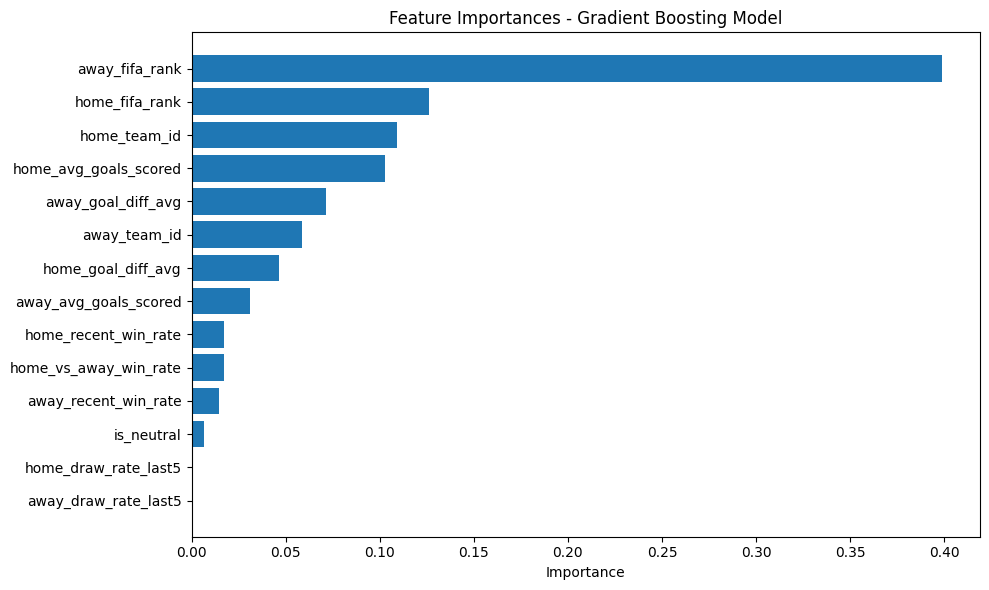

In [48]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['is_neutral'] = df['neutral'].astype(int)

# Keep matches with at least one qualified team
qualified_teams = [
    'Germany', 'Sweden', 'Denmark', 'France', 'Spain', 'Portugal', 'Poland', 'Bosnia and Herzegovina',
    'Italy', 'Belgium', 'England', 'Croatia', 'Egypt', 'Senegal', 'Nigeria', 'Cabo Verde', 'Congo DR',
    'Gabon', 'Mozambique', 'Sao Tome & Principe', 'Ghana', 'China', 'Iran', 'Iraq', 'UAE', 'Afghanistan',
    'Japan', 'Brazil', 'Uruguay', 'Colombia', 'Argentina', 'Venezuela', 'Ecuador', 'USA', 'Mexico',
    'Canada', 'St. Kitts and Nevis', 'Curacao', 'Costa Rica', 'Panama', 'Fiji', 'Lebanon', 'Barbados'
]
df = df[df['home_team'].isin(qualified_teams) | df['away_team'].isin(qualified_teams)].copy()

# Drop draws and encode result
df = df[df['home_score'] != df['away_score']].copy()
df['result'] = np.where(df['home_score'] > df['away_score'], 1, 0)

# -----------------------------
# Add FIFA rankings
# -----------------------------
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Congo DR': 61, 'Afghanistan': 151, 'UAE': 69,
    'Sao Tome & Principe': 184, 'Mozambique': 113
}
df['home_fifa_rank'] = df['home_team'].map(fifa_ranking).fillna(999)
df['away_fifa_rank'] = df['away_team'].map(fifa_ranking).fillna(999)

# -----------------------------
# Feature engineering (if not already present)
# -----------------------------
for col in ['home_recent_win_rate', 'away_recent_win_rate',
            'home_vs_away_win_rate', 'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    if col not in df.columns:
        df[col] = 0.0

team_histories = {}

def update_stats(team, score_for, score_against):
    hist = team_histories.get(team, [])
    hist.append({
        'gf': score_for,
        'ga': score_against,
        'win': int(score_for > score_against),
        'draw': int(score_for == score_against),
        'gd': score_for - score_against
    })
    if len(hist) > 5:
        hist.pop(0)
    team_histories[team] = hist
    return hist

for i, row in df.iterrows():
    home, away = row['home_team'], row['away_team']
    hs, as_ = row['home_score'], row['away_score']

    h_hist = team_histories.get(home, [])
    a_hist = team_histories.get(away, [])

    if h_hist:
        df.at[i, 'home_recent_win_rate'] = np.mean([m['win'] for m in h_hist])
        df.at[i, 'home_draw_rate_last5'] = np.mean([m['draw'] for m in h_hist])
        df.at[i, 'home_goal_diff_avg'] = np.mean([m['gd'] for m in h_hist])
        df.at[i, 'home_avg_goals_scored'] = np.mean([m['gf'] for m in h_hist])
    if a_hist:
        df.at[i, 'away_recent_win_rate'] = np.mean([m['win'] for m in a_hist])
        df.at[i, 'away_draw_rate_last5'] = np.mean([m['draw'] for m in a_hist])
        df.at[i, 'away_goal_diff_avg'] = np.mean([m['gd'] for m in a_hist])
        df.at[i, 'away_avg_goals_scored'] = np.mean([m['gf'] for m in a_hist])

    h2h = df[(df['home_team'] == home) & (df['away_team'] == away) & (df.index < i)]
    if len(h2h) > 0:
        wins = (h2h['home_score'] > h2h['away_score']).sum()
        df.at[i, 'home_vs_away_win_rate'] = wins / len(h2h)

    update_stats(home, hs, as_)
    update_stats(away, as_, hs)

df.fillna(0.0, inplace=True)

# -----------------------------
# Encode teams
# -----------------------------
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)

with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

# -----------------------------
# Train model
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored', 'home_fifa_rank', 'away_fifa_rank'
]

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

# -----------------------------
# Evaluate and save
# -----------------------------
print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, grid.predict(X_test)))

joblib.dump(grid.best_estimator_, "best_gb_knockout_model.joblib")
print("✅ Model saved as best_gb_knockout_model.joblib")

import matplotlib.pyplot as plt

# -----------------------------
# Feature Importance
# -----------------------------
importances = grid.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print
print("\n🔍 Feature Importances:")
print(feature_importance_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import joblib
import random
import json

    # -----------------------------
    # Load trained model & team encoding
    # -----------------------------
    model = joblib.load("best_gb_knockout_model.joblib")

    with open("team_to_id.json", "r") as f:
        team_to_id = json.load(f)

    # -----------------------------
    # FIFA Rankings
    # -----------------------------
    fifa_ranking = {
        'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
        'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
        'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
        'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
        'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
        'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
        'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
        'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
        'Nigeria': 38, 'Czechia': 41, 'Estonia': 111, 'UAE': 69
    }

    # -----------------------------
    # Round of 32 teams
    # -----------------------------
    qualified_teams = [
        'Argentina', 'France', 'Brazil', 'England', 'Belgium', 'Croatia', 'Portugal', 'Spain',
        'Italy', 'Germany', 'Uruguay', 'USA', 'Japan', 'Nigeria', 'Czechia', 'Estonia',
        'Austria', 'Iraq', 'Costa Rica', 'Iran', 'China', 'Gabon', 'Canada', 'Cabo Verde',
        'UAE', 'Panama', 'Poland', 'Ghana', 'South Korea', 'Sweden', 'Mexico', 'Slovakia'
    ]

    random.shuffle(qualified_teams)
    current_round = [(qualified_teams[i], qualified_teams[i + 1]) for i in range(0, 32, 2)]

    # -----------------------------
    # Match simulation
    # -----------------------------
    def simulate_match(home_team, away_team):
        home_id = team_to_id.get(home_team, 999)
        away_id = team_to_id.get(away_team, 999)
        home_rank = fifa_ranking.get(home_team, 999)
        away_rank = fifa_ranking.get(away_team, 999)

        match_features = pd.DataFrame([{
            'home_team_id': home_id,
            'away_team_id': away_id,
            'is_neutral': 1,
            'home_recent_win_rate': 0.5,
            'away_recent_win_rate': 0.5,
            'home_vs_away_win_rate': 0.5,
            'home_goal_diff_avg': 0.0,
            'away_goal_diff_avg': 0.0,
            'home_draw_rate_last5': 0.2,
            'away_draw_rate_last5': 0.2,
            'home_avg_goals_scored': 1.2,
            'away_avg_goals_scored': 1.2,
            'home_fifa_rank': home_rank,
            'away_fifa_rank': away_rank
        }])

        result = model.predict(match_features)[0]
        return home_team if result == 1 else away_team

    # -----------------------------
    # Run full knockout simulation
    # -----------------------------
    round_names = ["🏆 Round of 32", "🏅 Round of 16", "🥉 Quarterfinals", "🥈 Semifinals", "🥇 Final"]

    for round_name in round_names:
        print(f"\n{round_name}:")
        next_round = []
        for match in current_round:
            winner = simulate_match(*match)
            print(f"{match[0]} vs {match[1]} → ✅ {winner}")
            next_round.append(winner)

        if len(next_round) == 1:
            champion = next_round[0]
            break

        current_round = [(next_round[i], next_round[i + 1]) for i in range(0, len(next_round), 2)]

    # Final result
    print(f"\n🏆 FINAL: {current_round[0][0]} vs {current_round[0][1]} → 🏆 Champion: {champion} 🏆")


🏆 Round of 32:
Portugal vs Panama → ✅ Portugal
Cabo Verde vs Germany → ✅ Germany
England vs Canada → ✅ England
Gabon vs Croatia → ✅ Croatia
France vs Spain → ✅ Spain
Sweden vs Italy → ✅ Italy
South Korea vs China → ✅ South Korea
Japan vs Belgium → ✅ Belgium
Brazil vs USA → ✅ Brazil
UAE vs Iraq → ✅ UAE
Mexico vs Argentina → ✅ Argentina
Ghana vs Estonia → ✅ Ghana
Czechia vs Iran → ✅ Iran
Uruguay vs Poland → ✅ Uruguay
Nigeria vs Slovakia → ✅ Nigeria
Costa Rica vs Austria → ✅ Costa Rica

🏅 Round of 16:
Portugal vs Germany → ✅ Portugal
England vs Croatia → ✅ Croatia
Spain vs Italy → ✅ Spain
South Korea vs Belgium → ✅ Belgium
Brazil vs UAE → ✅ Brazil
Argentina vs Ghana → ✅ Argentina
Iran vs Uruguay → ✅ Uruguay
Nigeria vs Costa Rica → ✅ Nigeria

🥉 Quarterfinals:
Portugal vs Croatia → ✅ Portugal
Spain vs Belgium → ✅ Belgium
Brazil vs Argentina → ✅ Argentina
Uruguay vs Nigeria → ✅ Uruguay

🥈 Semifinals:
Portugal vs Belgium → ✅ Portugal
Argentina vs Uruguay → ✅ Uruguay

🥇 Final:
Portugal vs Uru

Run model 10,000 times to find percentage chance of teams winning

In [47]:
import pandas as pd
import numpy as np
import joblib
import random
import json

# -----------------------------
# Load trained model & encodings
# -----------------------------
model = joblib.load("best_gb_knockout_model.joblib")

with open("team_to_id.json", "r") as f:
    team_to_id = json.load(f)

# -----------------------------
# FIFA Rankings
# -----------------------------
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Czechia': 41, 'Estonia': 111, 'UAE': 69
}

# -----------------------------
# Qualified Teams (Round of 32)
# -----------------------------
qualified_teams = [
    'Argentina', 'France', 'Brazil', 'England', 'Belgium', 'Croatia', 'Portugal', 'Spain',
    'Italy', 'Germany', 'Uruguay', 'USA', 'Japan', 'Nigeria', 'Czechia', 'Estonia',
    'Austria', 'Iraq', 'Costa Rica', 'Iran', 'China', 'Gabon', 'Canada', 'Cabo Verde',
    'UAE', 'Panama', 'Poland', 'Ghana', 'South Korea', 'Sweden', 'Mexico', 'Slovakia'
]

# -----------------------------
# Match Simulation Function
# -----------------------------
def simulate_match(home_team, away_team):
    home_id = team_to_id.get(home_team, 999)
    away_id = team_to_id.get(away_team, 999)
    home_rank = fifa_ranking.get(home_team, 999)
    away_rank = fifa_ranking.get(away_team, 999)

    match_features = pd.DataFrame([{
        'home_team_id': home_id,
        'away_team_id': away_id,
        'is_neutral': 1,
        'home_recent_win_rate': 0.5,
        'away_recent_win_rate': 0.5,
        'home_vs_away_win_rate': 0.5,
        'home_goal_diff_avg': 0.0,
        'away_goal_diff_avg': 0.0,
        'home_draw_rate_last5': 0.2,
        'away_draw_rate_last5': 0.2,
        'home_avg_goals_scored': 1.2,
        'away_avg_goals_scored': 1.2,
        'home_fifa_rank': home_rank,
        'away_fifa_rank': away_rank
    }])

    result = model.predict(match_features)[0]
    return home_team if result == 1 else away_team

# -----------------------------
# Run Tournament 10,000 Times
# -----------------------------
champion_counts = {team: 0 for team in qualified_teams}

for _ in range(10000):
    teams = qualified_teams.copy()
    random.shuffle(teams)
    current_round = [(teams[i], teams[i + 1]) for i in range(0, 32, 2)]

    while len(current_round) > 1:
        winners = [simulate_match(*match) for match in current_round]
        current_round = [(winners[i], winners[i + 1]) for i in range(0, len(winners), 2)]

    finalist1, finalist2 = current_round[0]
    champion = simulate_match(finalist1, finalist2)
    champion_counts[champion] += 1

# -----------------------------
# Output Win Percentages
# -----------------------------
print("\n🏆 Champion Win Percentages (10,000 Simulations):")
for team, wins in sorted(champion_counts.items(), key=lambda x: -x[1]):
    percent = (wins / 10000) * 100
    print(f"{team}: {wins} wins — {percent:.5f}%")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- common_opponent_score_diff


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77        40
           1       0.86      0.82      0.84        60

    accuracy                           0.81       100
   macro avg       0.80      0.81      0.80       100
weighted avg       0.81      0.81      0.81       100

✅ Model saved as gb_model_without_fifa.joblib

🔍 Feature Importances:
                  Feature  Importance
7      away_goal_diff_avg    0.246842
0            home_team_id    0.216719
1            away_team_id    0.193164
10  home_avg_goals_scored    0.118230
6      home_goal_diff_avg    0.081317
11  away_avg_goals_scored    0.054531
3    home_recent_win_rate    0.043574
4    away_recent_win_rate    0.022900
5   home_vs_away_win_rate    0.015724
2              is_neutral    0.007000
8    home_draw_rate_last5    0.000000
9    away_draw_rate_la

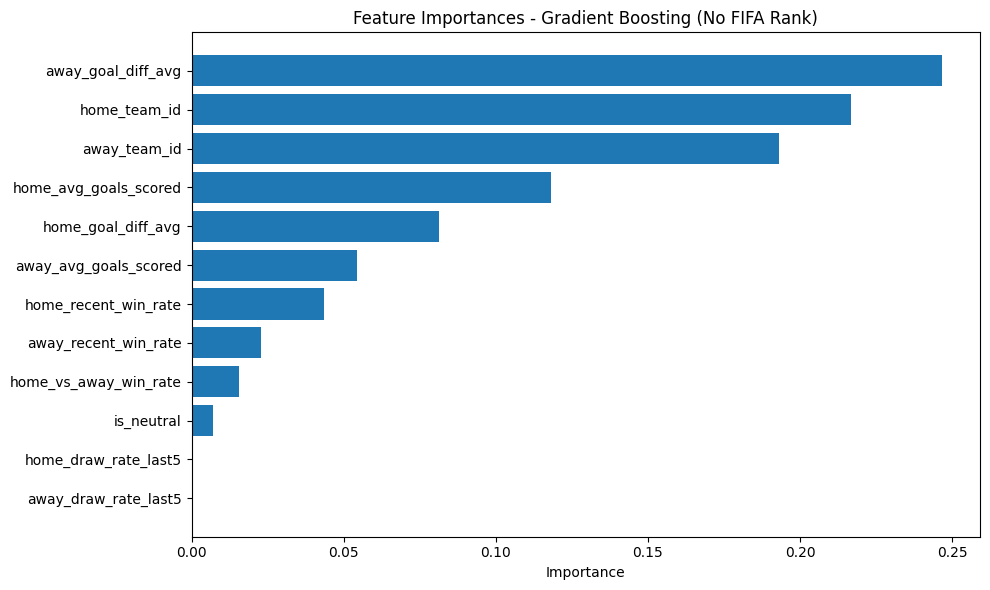

In [30]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['is_neutral'] = df['neutral'].astype(int)

# Keep matches with at least one qualified team
qualified_teams = [
    'Germany', 'Sweden', 'Denmark', 'France', 'Spain', 'Portugal', 'Poland', 'Bosnia and Herzegovina',
    'Italy', 'Belgium', 'England', 'Croatia', 'Egypt', 'Senegal', 'Nigeria', 'Cabo Verde', 'Congo DR',
    'Gabon', 'Mozambique', 'Sao Tome & Principe', 'Ghana', 'China', 'Iran', 'Iraq', 'UAE', 'Afghanistan',
    'Japan', 'Brazil', 'Uruguay', 'Colombia', 'Argentina', 'Venezuela', 'Ecuador', 'USA', 'Mexico',
    'Canada', 'St. Kitts and Nevis', 'Curacao', 'Costa Rica', 'Panama', 'Fiji', 'Lebanon', 'Barbados'
]
df = df[df['home_team'].isin(qualified_teams) | df['away_team'].isin(qualified_teams)].copy()

# Drop draws and encode result
df = df[df['home_score'] != df['away_score']].copy()
df['result'] = np.where(df['home_score'] > df['away_score'], 1, 0)

# -----------------------------
# Feature engineering
# -----------------------------
for col in ['home_recent_win_rate', 'away_recent_win_rate',
            'home_vs_away_win_rate', 'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    if col not in df.columns:
        df[col] = 0.0

team_histories = {}

def update_stats(team, score_for, score_against):
    hist = team_histories.get(team, [])
    hist.append({
        'gf': score_for,
        'ga': score_against,
        'win': int(score_for > score_against),
        'draw': int(score_for == score_against),
        'gd': score_for - score_against
    })
    if len(hist) > 5:
        hist.pop(0)
    team_histories[team] = hist
    return hist

for i, row in df.iterrows():
    home, away = row['home_team'], row['away_team']
    hs, as_ = row['home_score'], row['away_score']

    h_hist = team_histories.get(home, [])
    a_hist = team_histories.get(away, [])

    if h_hist:
        df.at[i, 'home_recent_win_rate'] = np.mean([m['win'] for m in h_hist])
        df.at[i, 'home_draw_rate_last5'] = np.mean([m['draw'] for m in h_hist])
        df.at[i, 'home_goal_diff_avg'] = np.mean([m['gd'] for m in h_hist])
        df.at[i, 'home_avg_goals_scored'] = np.mean([m['gf'] for m in h_hist])
    if a_hist:
        df.at[i, 'away_recent_win_rate'] = np.mean([m['win'] for m in a_hist])
        df.at[i, 'away_draw_rate_last5'] = np.mean([m['draw'] for m in a_hist])
        df.at[i, 'away_goal_diff_avg'] = np.mean([m['gd'] for m in a_hist])
        df.at[i, 'away_avg_goals_scored'] = np.mean([m['gf'] for m in a_hist])

    h2h = df[(df['home_team'] == home) & (df['away_team'] == away) & (df.index < i)]
    if len(h2h) > 0:
        wins = (h2h['home_score'] > h2h['away_score']).sum()
        df.at[i, 'home_vs_away_win_rate'] = wins / len(h2h)

    update_stats(home, hs, as_)
    update_stats(away, as_, hs)

df.fillna(0.0, inplace=True)

# -----------------------------
# Encode teams
# -----------------------------
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)

with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

# -----------------------------
# Train model (without FIFA rank)
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate',
    'home_vs_away_win_rate', 'home_goal_diff_avg',
    'away_goal_diff_avg', 'home_draw_rate_last5',
    'away_draw_rate_last5', 'home_avg_goals_scored',
    'away_avg_goals_scored'
]

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

# -----------------------------
# Evaluate and save
# -----------------------------
print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, grid.predict(X_test)))

joblib.dump(grid.best_estimator_, "gb_model_without_fifa.joblib")
print("✅ Model saved as gb_model_without_fifa.joblib")

# -----------------------------
# Feature Importances
# -----------------------------
importances = grid.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔍 Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting (No FIFA Rank)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###Adding common opponents as an engineered feature#######

###Adding common opponents as an engineered feature#######

###Adding common opponents as an engineered feature#######

###Adding common opponents as an engineered feature#######

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.71        92
           1       0.80      0.84      0.82       140

    accuracy                           0.78       232
   macro avg       0.77      0.76      0.76       232
weighted avg       0.77      0.78      0.77       232


✅ Model saved as best_gb_knockout_model.joblib

🔍 Feature Importances:
                       Feature  Importance
7           away_goal_diff_avg    0.177474
6           home_goal_diff_avg    0.154367
12              home_fifa_rank    0.127776
13              away_fifa_rank    0.106347
1                 away_team_id    0.103069
0                 home_team_id    0.075653
11       away_avg_goals_scored    0.062228
14  common_opponent_score_diff    0.060634
19      common_diff_normalized    0.049581
10       home_avg_goals_scored    0.020574
2  

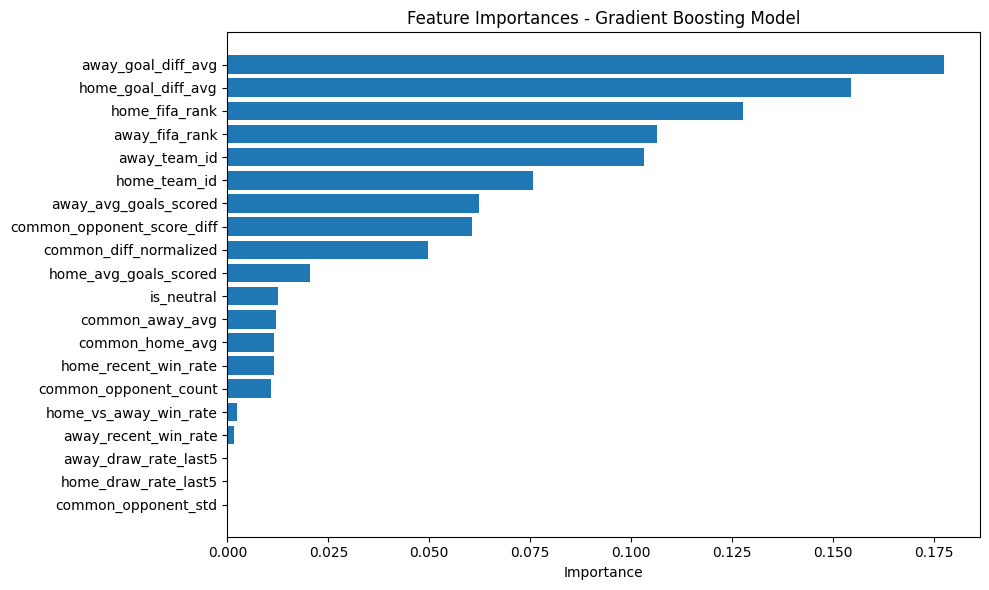

In [49]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['is_neutral'] = df['neutral'].astype(int)

# Drop draws and encode result
df = df[df['home_score'] != df['away_score']].copy()
df['result'] = np.where(df['home_score'] > df['away_score'], 1, 0)

# -----------------------------
# Add FIFA rankings
# -----------------------------
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Congo DR': 61, 'Afghanistan': 151, 'UAE': 69,
    'Sao Tome & Principe': 184, 'Mozambique': 113
}
df['home_fifa_rank'] = df['home_team'].map(fifa_ranking).fillna(999)
df['away_fifa_rank'] = df['away_team'].map(fifa_ranking).fillna(999)

# -----------------------------
# Feature engineering
# -----------------------------
team_histories = {}
for col in ['home_recent_win_rate', 'away_recent_win_rate', 'home_vs_away_win_rate',
            'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    df[col] = 0.0

def update_stats(team, score_for, score_against):
    hist = team_histories.get(team, [])
    hist.append({
        'gf': score_for,
        'ga': score_against,
        'win': int(score_for > score_against),
        'draw': int(score_for == score_against),
        'gd': score_for - score_against
    })
    if len(hist) > 5:
        hist.pop(0)
    team_histories[team] = hist
    return hist

def get_common_opponent_metrics(row):
    home, away = row['home_team'], row['away_team']
    date = row['date']
    prior_matches = df[df['date'] < date]
    common_teams = set(prior_matches[prior_matches['home_team'] == home]['away_team']) & \
                   set(prior_matches[prior_matches['home_team'] == away]['away_team'])
    diffs, scores_home, scores_away = [], [], []

    for team in common_teams:
        h_matches = prior_matches[((prior_matches['home_team'] == home) & (prior_matches['away_team'] == team)) |
                                  ((prior_matches['away_team'] == home) & (prior_matches['home_team'] == team))]
        a_matches = prior_matches[((prior_matches['home_team'] == away) & (prior_matches['away_team'] == team)) |
                                  ((prior_matches['away_team'] == away) & (prior_matches['home_team'] == team))]
        for h in h_matches.itertuples():
            h_diff = h.home_score - h.away_score if h.home_team == home else h.away_score - h.home_score
            for a in a_matches.itertuples():
                a_diff = a.home_score - a.away_score if a.home_team == away else a.away_score - a.home_score
                diffs.append(h_diff - a_diff)
                scores_home.append(h_diff)
                scores_away.append(a_diff)

    if diffs:
        mean_diff = np.mean(diffs)
        mean_home_score = np.mean(scores_home)
        mean_away_score = np.mean(scores_away)
        return pd.Series([mean_diff, mean_home_score, mean_away_score, len(diffs),
                          np.std(diffs), mean_diff / (np.mean([abs(x) for x in scores_home + scores_away]) + 1e-6)])
    return pd.Series([0.0, 0.0, 0.0, 0, 0.0, 0.0])

common_cols = ['common_opponent_score_diff', 'common_home_avg', 'common_away_avg',
               'common_opponent_count', 'common_opponent_std', 'common_diff_normalized']

df[common_cols] = df.apply(get_common_opponent_metrics, axis=1)

for i, row in df.iterrows():
    home, away = row['home_team'], row['away_team']
    hs, as_ = row['home_score'], row['away_score']

    h_hist = team_histories.get(home, [])
    a_hist = team_histories.get(away, [])

    if h_hist:
        df.at[i, 'home_recent_win_rate'] = np.mean([m['win'] for m in h_hist])
        df.at[i, 'home_draw_rate_last5'] = np.mean([m['draw'] for m in h_hist])
        df.at[i, 'home_goal_diff_avg'] = np.mean([m['gd'] for m in h_hist])
        df.at[i, 'home_avg_goals_scored'] = np.mean([m['gf'] for m in h_hist])
    if a_hist:
        df.at[i, 'away_recent_win_rate'] = np.mean([m['win'] for m in a_hist])
        df.at[i, 'away_draw_rate_last5'] = np.mean([m['draw'] for m in a_hist])
        df.at[i, 'away_goal_diff_avg'] = np.mean([m['gd'] for m in a_hist])
        df.at[i, 'away_avg_goals_scored'] = np.mean([m['gf'] for m in a_hist])

    h2h = df[(df['home_team'] == home) & (df['away_team'] == away) & (df.index < i)]
    if len(h2h) > 0:
        wins = (h2h['home_score'] > h2h['away_score']).sum()
        df.at[i, 'home_vs_away_win_rate'] = wins / len(h2h)

    update_stats(home, hs, as_)
    update_stats(away, as_, hs)

df.fillna(0.0, inplace=True)

# -----------------------------
# Encode teams
# -----------------------------
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)

with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

# -----------------------------
# Train model
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_recent_win_rate', 'away_recent_win_rate', 'home_vs_away_win_rate',
    'home_goal_diff_avg', 'away_goal_diff_avg', 'home_draw_rate_last5', 'away_draw_rate_last5',
    'home_avg_goals_scored', 'away_avg_goals_scored', 'home_fifa_rank', 'away_fifa_rank',
    'common_opponent_score_diff', 'common_home_avg', 'common_away_avg',
    'common_opponent_count', 'common_opponent_std', 'common_diff_normalized'
]

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

# -----------------------------
# Evaluate and save
# -----------------------------
print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, grid.predict(X_test)))

joblib.dump(grid.best_estimator_, "best_gb_knockout_model.joblib")
print("\n✅ Model saved as best_gb_knockout_model.joblib")

# -----------------------------
# Feature Importance
# -----------------------------
importances = grid.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔍 Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
import numpy as np
import joblib
import random
import json

# -----------------------------
# Load trained model & encodings
# -----------------------------
model = joblib.load("best_gb_knockout_model.joblib")

with open("team_to_id.json", "r") as f:
    team_to_id = json.load(f)

# -----------------------------
# FIFA Rankings
# -----------------------------
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Czechia': 41, 'Estonia': 111, 'UAE': 69
}

# -----------------------------
# Qualified Teams (Round of 32)
# -----------------------------
qualified_teams = [
    'Argentina', 'France', 'Brazil', 'England', 'Belgium', 'Croatia', 'Portugal', 'Spain',
    'Italy', 'Germany', 'Uruguay', 'USA', 'Japan', 'Nigeria', 'Czechia', 'Estonia',
    'Austria', 'Iraq', 'Costa Rica', 'Iran', 'China', 'Gabon', 'Canada', 'Cabo Verde',
    'UAE', 'Panama', 'Poland', 'Ghana', 'South Korea', 'Sweden', 'Mexico', 'Slovakia'
]

# -----------------------------
# Simulated Historical Results Dictionary
# -----------------------------
# Replace this with real match history if available
simulated_history = {
    ('Mexico', 'Spain'): (1, 2),
    ('Japan', 'Spain'): (0, 1),
    ('Mexico', 'France'): (2, 1),
    ('Japan', 'France'): (1, 3),
    # Add more pairs as needed
}

def common_opponent_diff(home, away):
    diffs = []
    for (team1, team2), (score1, score2) in simulated_history.items():
        if (team1 == home and team2 != away) or (team2 == home and team1 != away):
            for (t1, t2), (s1, s2) in simulated_history.items():
                if ((t1 == away and t2 == team2) or (t2 == away and t1 == team2)) and (team2 == t2 or team2 == t1):
                    # Calculate goal difference comparison
                    home_diff = score1 - score2 if team1 == home else score2 - score1
                    away_diff = s1 - s2 if t1 == away else s2 - s1
                    diffs.append(home_diff - away_diff)
    return np.mean(diffs) if diffs else 0.0

# -----------------------------
# Match Simulation Function
# -----------------------------
def simulate_match(home_team, away_team):
    home_id = team_to_id.get(home_team, 999)
    away_id = team_to_id.get(away_team, 999)
    home_rank = fifa_ranking.get(home_team, 999)
    away_rank = fifa_ranking.get(away_team, 999)

    match_features = pd.DataFrame([{
        'home_team_id': home_id,
        'away_team_id': away_id,
        'is_neutral': 1,
        'home_recent_win_rate': 0.5,
        'away_recent_win_rate': 0.5,
        'home_vs_away_win_rate': 0.5,
        'home_goal_diff_avg': 0.0,
        'away_goal_diff_avg': 0.0,
        'home_draw_rate_last5': 0.2,
        'away_draw_rate_last5': 0.2,
        'home_avg_goals_scored': 1.2,
        'away_avg_goals_scored': 1.2,
        'home_fifa_rank': home_rank,
        'away_fifa_rank': away_rank,
        'common_opponent_score_diff': common_opponent_diff(home_team, away_team)
    }])

    result = model.predict(match_features)[0]
    return home_team if result == 1 else away_team

# -----------------------------
# Run Tournament 10,000 Times
# -----------------------------
champion_counts = {team: 0 for team in qualified_teams}

for _ in range(10000):
    teams = qualified_teams.copy()
    random.shuffle(teams)
    current_round = [(teams[i], teams[i + 1]) for i in range(0, 32, 2)]

    while len(current_round) > 1:
        winners = [simulate_match(*match) for match in current_round]
        current_round = [(winners[i], winners[i + 1]) for i in range(0, len(winners), 2)]

    finalist1, finalist2 = current_round[0]
    champion = simulate_match(finalist1, finalist2)
    champion_counts[champion] += 1

# -----------------------------
# Output Win Percentages
# -----------------------------
print("\n🏆 Champion Win Percentages (10,000 Simulations):")
for team, wins in sorted(champion_counts.items(), key=lambda x: -x[1]):
    percent = (wins / 10000) * 100
    print(f"{team}: {wins} wins — {percent:.5f}%")

KeyboardInterrupt: 

###STacking model with common opponent feature and model without it#####
adding recent head to head

###STacking model with common opponent feature and model without it#####
adding recent head to head

###STacking model with common opponent feature and model without it#####
adding recent head to head

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        40
           1       0.85      0.92      0.88        60

    accuracy                           0.85       100
   macro avg       0.85      0.83      0.84       100
weighted avg       0.85      0.85      0.85       100


✅ Model saved as best_gb_knockout_model.joblib

🔍 Feature Importances:
                   Feature  Importance
14  common_diff_normalized    0.675817
11        common_away_diff    0.052133
4       away_goal_diff_avg    0.039441
8           away_fifa_rank    0.037016
12         common_home_avg    0.031814
1             away_team_id    0.031194
3       home_goal_diff_avg    0.028494
0             home_team_id    0.028159
13         common_away_avg    0.020208
6    away_avg_goals_scored    0.015577
10        common_home_diff    0.011799
5    hom

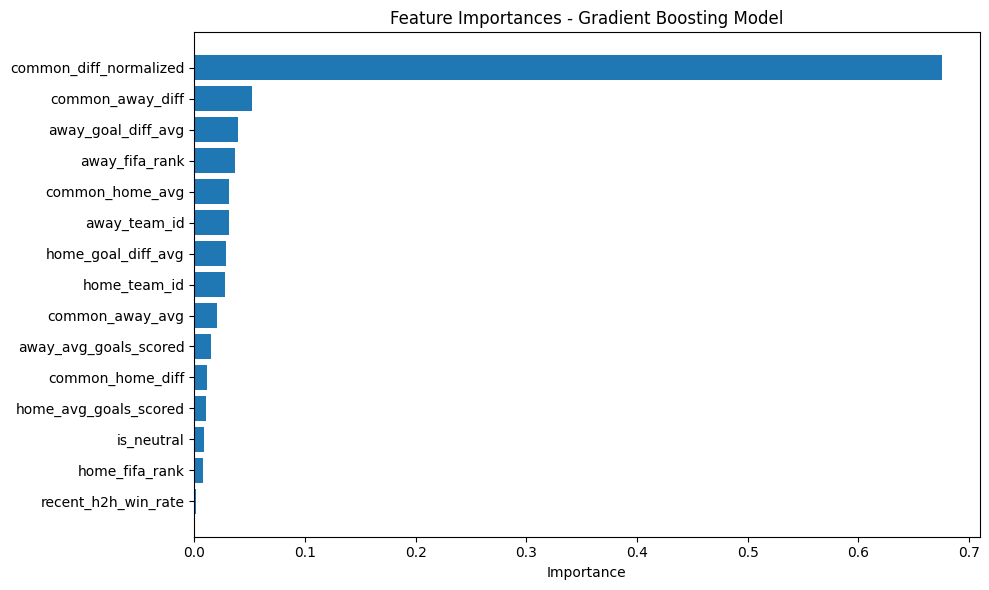

In [59]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['is_neutral'] = df['neutral'].astype(int)

qualified_teams = [
    'Germany', 'Sweden', 'Denmark', 'France', 'Spain', 'Portugal', 'Poland', 'Bosnia and Herzegovina',
    'Italy', 'Belgium', 'England', 'Croatia', 'Egypt', 'Senegal', 'Nigeria', 'Cabo Verde', 'Congo DR',
    'Gabon', 'Mozambique', 'Sao Tome & Principe', 'Ghana', 'China', 'Iran', 'Iraq', 'UAE', 'Afghanistan',
    'Japan', 'Brazil', 'Uruguay', 'Colombia', 'Argentina', 'Venezuela', 'Ecuador', 'USA', 'Mexico',
    'Canada', 'St. Kitts and Nevis', 'Curacao', 'Costa Rica', 'Panama', 'Fiji', 'Lebanon', 'Barbados'
]
df = df[df['home_team'].isin(qualified_teams) | df['away_team'].isin(qualified_teams)].copy()

# Drop draws and encode result
df = df[df['home_score'] != df['away_score']].copy()
df['result'] = np.where(df['home_score'] > df['away_score'], 1, 0)

# FIFA Rankings
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Congo DR': 61, 'Afghanistan': 151, 'UAE': 69,
    'Sao Tome & Principe': 184, 'Mozambique': 113
}
df['home_fifa_rank'] = df['home_team'].map(fifa_ranking).fillna(999)
df['away_fifa_rank'] = df['away_team'].map(fifa_ranking).fillna(999)

# -----------------------------
# Feature Engineering
# -----------------------------
for col in ['home_recent_win_rate', 'away_recent_win_rate',
            'home_vs_away_win_rate', 'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    if col not in df.columns:
        df[col] = 0.0

team_histories = {}
h2h_history = {}
df['recent_h2h_win_rate'] = 0.0

for i, row in df.iterrows():
    home, away = row['home_team'], row['away_team']
    hs, as_ = row['home_score'], row['away_score']

    h_hist = team_histories.get(home, [])
    a_hist = team_histories.get(away, [])

    if h_hist:
        df.at[i, 'home_recent_win_rate'] = np.mean([m['win'] for m in h_hist])
        df.at[i, 'home_draw_rate_last5'] = np.mean([m['draw'] for m in h_hist])
        df.at[i, 'home_goal_diff_avg'] = np.mean([m['gd'] for m in h_hist])
        df.at[i, 'home_avg_goals_scored'] = np.mean([m['gf'] for m in h_hist])
    if a_hist:
        df.at[i, 'away_recent_win_rate'] = np.mean([m['win'] for m in a_hist])
        df.at[i, 'away_draw_rate_last5'] = np.mean([m['draw'] for m in a_hist])
        df.at[i, 'away_goal_diff_avg'] = np.mean([m['gd'] for m in a_hist])
        df.at[i, 'away_avg_goals_scored'] = np.mean([m['gf'] for m in a_hist])

    match_key = (home, away)
    history = h2h_history.get(match_key, [])
    if history:
        recent = history[-5:]
        df.at[i, 'recent_h2h_win_rate'] = np.mean(recent)
    history.append(int(row['result'] == 1))
    h2h_history[match_key] = history

    h2h = df[(df['home_team'] == home) & (df['away_team'] == away) & (df.index < i)]
    if len(h2h) > 0:
        wins = (h2h['home_score'] > h2h['away_score']).sum()
        df.at[i, 'home_vs_away_win_rate'] = wins / len(h2h)

    def update_stats(team, score_for, score_against):
        hist = team_histories.get(team, [])
        hist.append({
            'gf': score_for,
            'ga': score_against,
            'win': int(score_for > score_against),
            'draw': int(score_for == score_against),
            'gd': score_for - score_against
        })
        if len(hist) > 5:
            hist.pop(0)
        team_histories[team] = hist

    update_stats(home, hs, as_)
    update_stats(away, as_, hs)

# -----------------------------
# Common Opponent Feature
# -----------------------------
def compute_common_opponent_diff(row, df):
    home, away = row['home_team'], row['away_team']
    past_home = df[(df['home_team'] == home) | (df['away_team'] == home)]
    past_away = df[(df['home_team'] == away) | (df['away_team'] == away)]
    common_teams = set(pd.concat([past_home['home_team'], past_home['away_team']])) & \
                   set(pd.concat([past_away['home_team'], past_away['away_team']]))

    h_diff, a_diff, h_score, a_score = [], [], [], []
    for team in common_teams:
        h_games = past_home[(past_home['home_team'] == team) | (past_home['away_team'] == team)]
        a_games = past_away[(past_away['home_team'] == team) | (past_away['away_team'] == team)]

        h_diffs = h_games.apply(lambda x: x['home_score'] - x['away_score'] if x['home_team'] == home else x['away_score'] - x['home_score'], axis=1)
        a_diffs = a_games.apply(lambda x: x['home_score'] - x['away_score'] if x['home_team'] == away else x['away_score'] - x['home_score'], axis=1)

        h_diff.extend(h_diffs)
        a_diff.extend(a_diffs)
        h_score.extend(h_games.apply(lambda x: x['home_score'] if x['home_team'] == home else x['away_score'], axis=1))
        a_score.extend(a_games.apply(lambda x: x['home_score'] if x['home_team'] == away else x['away_score'], axis=1))

    h_avg = np.mean(h_diff) if h_diff else 0
    a_avg = np.mean(a_diff) if a_diff else 0
    h_score_avg = np.mean(h_score) if h_score else 0
    a_score_avg = np.mean(a_score) if a_score else 0
    interaction = (h_avg - a_avg) / ((h_score_avg + a_score_avg) / 2 + 1e-6)

    return pd.Series([h_avg, a_avg, h_score_avg, a_score_avg, interaction])

df[['common_home_diff', 'common_away_diff', 'common_home_avg', 'common_away_avg', 'common_diff_normalized']] = \
    df.apply(lambda row: compute_common_opponent_diff(row, df), axis=1)

# -----------------------------
# Encode team names
# -----------------------------
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)
with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

# -----------------------------
# Train model
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_goal_diff_avg', 'away_goal_diff_avg',
    'home_avg_goals_scored', 'away_avg_goals_scored',
    'home_fifa_rank', 'away_fifa_rank',
    'recent_h2h_win_rate',
    'common_home_diff', 'common_away_diff',
    'common_home_avg', 'common_away_avg',
    'common_diff_normalized'
]

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, grid.predict(X_test)))

joblib.dump(grid.best_estimator_, "best_gb_knockout_model.joblib")
print("\n✅ Model saved as best_gb_knockout_model.joblib")

importances = grid.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔍 Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [64]:
import pandas as pd
import numpy as np
import joblib
import random
import json

# -----------------------------
# Load trained model & encodings
# -----------------------------
model = joblib.load("best_gb_knockout_model.joblib")

with open("team_to_id.json", "r") as f:
    team_to_id = json.load(f)

# -----------------------------
# FIFA Rankings
# -----------------------------
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Czechia': 41, 'Estonia': 111, 'UAE': 69
}

# -----------------------------
# Qualified Teams (Round of 32)
# -----------------------------
qualified_teams = [
    'Argentina', 'France', 'Brazil', 'England', 'Belgium', 'Croatia', 'Portugal', 'Spain',
    'Italy', 'Germany', 'Uruguay', 'USA', 'Japan', 'Nigeria', 'Czechia', 'Estonia',
    'Austria', 'Iraq', 'Costa Rica', 'Iran', 'China', 'Gabon', 'Canada', 'Cabo Verde',
    'UAE', 'Panama', 'Poland', 'Ghana', 'South Korea', 'Sweden', 'Mexico', 'Slovakia'
]

# -----------------------------
# Simulated Historical Results Dictionary (for common opponent diff)
# -----------------------------
simulated_history = {
    ('Mexico', 'Spain'): (1, 2),
    ('Japan', 'Spain'): (0, 1),
    ('Mexico', 'France'): (2, 1),
    ('Japan', 'France'): (1, 3),
    # Add more pairs as needed
}

def compute_common_features(home, away):
    # Placeholder static values; can be improved with real game data
    return {
        'common_home_diff': 0.0,
        'common_away_diff': 0.0,
        'common_home_avg': 1.0,
        'common_away_avg': 1.0,
        'common_diff_normalized': 0.0
    }

def simulate_match(home_team, away_team):
    home_id = team_to_id.get(home_team, 999)
    away_id = team_to_id.get(away_team, 999)
    home_rank = fifa_ranking.get(home_team, 999)
    away_rank = fifa_ranking.get(away_team, 999)
    common_feats = compute_common_features(home_team, away_team)

    match_features = pd.DataFrame([{
        'home_team_id': home_id,
        'away_team_id': away_id,
        'is_neutral': 1,
        'home_goal_diff_avg': 0.0,
        'away_goal_diff_avg': 0.0,
        'home_avg_goals_scored': 1.2,
        'away_avg_goals_scored': 1.2,
        'home_fifa_rank': home_rank,
        'away_fifa_rank': away_rank,
        'recent_h2h_win_rate': 0.5,
        **common_feats
    }])

    result = model.predict(match_features)[0]
    return home_team if result == 1 else away_team

# -----------------------------
# Run Tournament 10,000 Times
# -----------------------------
champion_counts = {team: 0 for team in qualified_teams}

for _ in range(1000):
    teams = qualified_teams.copy()
    random.shuffle(teams)
    current_round = [(teams[i], teams[i + 1]) for i in range(0, 32, 2)]

    while len(current_round) > 1:
        winners = [simulate_match(*match) for match in current_round]
        current_round = [(winners[i], winners[i + 1]) for i in range(0, len(winners), 2)]

    finalist1, finalist2 = current_round[0]
    champion = simulate_match(finalist1, finalist2)
    champion_counts[champion] += 1

# -----------------------------
# Output Win Percentages
# -----------------------------
print("\n\U0001F3C6 Champion Win Percentages (10,000 Simulations):")
for team, wins in sorted(champion_counts.items(), key=lambda x: -x[1]):
    percent = (wins / 10000) * 100
    print(f"{team}: {wins} wins — {percent:.5f}%")


🏆 Champion Win Percentages (10,000 Simulations):
France: 434 wins — 4.34000%
Argentina: 83 wins — 0.83000%
Uruguay: 72 wins — 0.72000%
Brazil: 69 wins — 0.69000%
Germany: 67 wins — 0.67000%
Mexico: 60 wins — 0.60000%
England: 38 wins — 0.38000%
Italy: 34 wins — 0.34000%
Portugal: 32 wins — 0.32000%
Spain: 30 wins — 0.30000%
Croatia: 29 wins — 0.29000%
Belgium: 28 wins — 0.28000%
Japan: 22 wins — 0.22000%
USA: 1 wins — 0.01000%
Iran: 1 wins — 0.01000%
Nigeria: 0 wins — 0.00000%
Czechia: 0 wins — 0.00000%
Estonia: 0 wins — 0.00000%
Austria: 0 wins — 0.00000%
Iraq: 0 wins — 0.00000%
Costa Rica: 0 wins — 0.00000%
China: 0 wins — 0.00000%
Gabon: 0 wins — 0.00000%
Canada: 0 wins — 0.00000%
Cabo Verde: 0 wins — 0.00000%
UAE: 0 wins — 0.00000%
Panama: 0 wins — 0.00000%
Poland: 0 wins — 0.00000%
Ghana: 0 wins — 0.00000%
South Korea: 0 wins — 0.00000%
Sweden: 0 wins — 0.00000%
Slovakia: 0 wins — 0.00000%


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        40
           1       0.85      0.85      0.85        60

    accuracy                           0.82       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.82      0.82      0.82       100


✅ Model saved as best_gb_knockout_model.joblib

🔍 Feature Importances:
                   Feature  Importance
8           away_fifa_rank    0.387235
7           home_fifa_rank    0.123962
5    home_avg_goals_scored    0.095881
0             home_team_id    0.084649
14  common_diff_normalized    0.076529
4       away_goal_diff_avg    0.050654
1             away_team_id    0.046510
6    away_avg_goals_scored    0.031662
10        common_home_diff    0.030053
3       home_goal_diff_avg    0.028846
11        common_away_diff    0.015588
13      

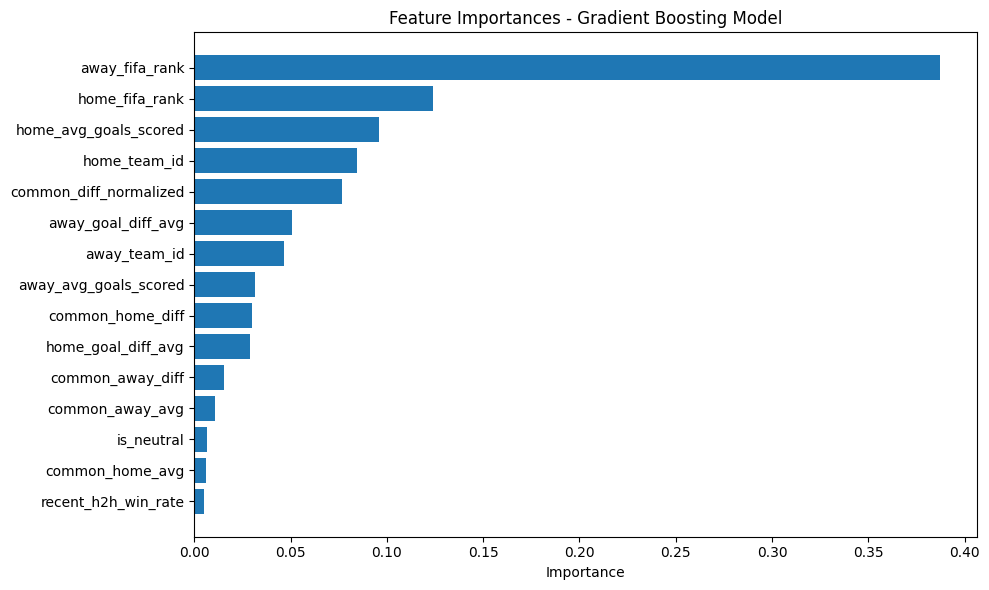

In [62]:
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv('/Users/julianp/Downloads/archive (6)/Book2.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['is_neutral'] = df['neutral'].astype(int)

qualified_teams = [
    'Germany', 'Sweden', 'Denmark', 'France', 'Spain', 'Portugal', 'Poland', 'Bosnia and Herzegovina',
    'Italy', 'Belgium', 'England', 'Croatia', 'Egypt', 'Senegal', 'Nigeria', 'Cabo Verde', 'Congo DR',
    'Gabon', 'Mozambique', 'Sao Tome & Principe', 'Ghana', 'China', 'Iran', 'Iraq', 'UAE', 'Afghanistan',
    'Japan', 'Brazil', 'Uruguay', 'Colombia', 'Argentina', 'Venezuela', 'Ecuador', 'USA', 'Mexico',
    'Canada', 'St. Kitts and Nevis', 'Curacao', 'Costa Rica', 'Panama', 'Fiji', 'Lebanon', 'Barbados'
]
df = df[df['home_team'].isin(qualified_teams) | df['away_team'].isin(qualified_teams)].copy()

# Drop draws and encode result
df = df[df['home_score'] != df['away_score']].copy()
df['result'] = np.where(df['home_score'] > df['away_score'], 1, 0)

# FIFA Rankings
fifa_ranking = {
    'Argentina': 1, 'France': 2, 'Brazil': 3, 'England': 4, 'Belgium': 5,
    'Croatia': 6, 'Portugal': 8, 'Spain': 9, 'Italy': 10, 'Germany': 11,
    'Uruguay': 12, 'USA': 13, 'Mexico': 14, 'Colombia': 15, 'Senegal': 16,
    'Japan': 17, 'Iran': 19, 'Denmark': 20, 'Sweden': 24, 'Poland': 28,
    'Canada': 49, 'Slovakia': 48, 'Ghana': 60, 'Iraq': 63, 'Bosnia and Herzegovina': 63,
    'China': 88, 'Qatar': 58, 'Saudi Arabia': 56, 'Lebanon': 104, 'Vietnam': 115,
    'Barbados': 164, 'Fiji': 176, 'Gabon': 86, 'Costa Rica': 52, 'Curacao': 90,
    'Panama': 45, 'St. Kitts and Nevis': 139, 'Cabo Verde': 73, 'Egypt': 36,
    'Nigeria': 38, 'Congo DR': 61, 'Afghanistan': 151, 'UAE': 69,
    'Sao Tome & Principe': 184, 'Mozambique': 113
}
df['home_fifa_rank'] = df['home_team'].map(fifa_ranking).fillna(999)
df['away_fifa_rank'] = df['away_team'].map(fifa_ranking).fillna(999)

# -----------------------------
# Feature Engineering
# -----------------------------
for col in ['home_recent_win_rate', 'away_recent_win_rate',
            'home_vs_away_win_rate', 'home_goal_diff_avg', 'away_goal_diff_avg',
            'home_draw_rate_last5', 'away_draw_rate_last5',
            'home_avg_goals_scored', 'away_avg_goals_scored']:
    if col not in df.columns:
        df[col] = 0.0

team_histories = {}
h2h_history = {}
df['recent_h2h_win_rate'] = 0.0

for i, row in df.iterrows():
    home, away = row['home_team'], row['away_team']
    hs, as_ = row['home_score'], row['away_score']

    h_hist = team_histories.get(home, [])
    a_hist = team_histories.get(away, [])

    if h_hist:
        df.at[i, 'home_recent_win_rate'] = np.mean([m['win'] for m in h_hist])
        df.at[i, 'home_draw_rate_last5'] = np.mean([m['draw'] for m in h_hist])
        df.at[i, 'home_goal_diff_avg'] = np.mean([m['gd'] for m in h_hist])
        df.at[i, 'home_avg_goals_scored'] = np.mean([m['gf'] for m in h_hist])
    if a_hist:
        df.at[i, 'away_recent_win_rate'] = np.mean([m['win'] for m in a_hist])
        df.at[i, 'away_draw_rate_last5'] = np.mean([m['draw'] for m in a_hist])
        df.at[i, 'away_goal_diff_avg'] = np.mean([m['gd'] for m in a_hist])
        df.at[i, 'away_avg_goals_scored'] = np.mean([m['gf'] for m in a_hist])

    match_key = (home, away)
    history = h2h_history.get(match_key, [])
    if history:
        recent = history[-5:]
        df.at[i, 'recent_h2h_win_rate'] = np.mean(recent)
    history.append(int(row['result'] == 1))
    h2h_history[match_key] = history

    h2h = df[(df['home_team'] == home) & (df['away_team'] == away) & (df.index < i)]
    if len(h2h) > 0:
        wins = (h2h['home_score'] > h2h['away_score']).sum()
        df.at[i, 'home_vs_away_win_rate'] = wins / len(h2h)

    def update_stats(team, score_for, score_against):
        hist = team_histories.get(team, [])
        hist.append({
            'gf': score_for,
            'ga': score_against,
            'win': int(score_for > score_against),
            'draw': int(score_for == score_against),
            'gd': score_for - score_against
        })
        if len(hist) > 5:
            hist.pop(0)
        team_histories[team] = hist

    update_stats(home, hs, as_)
    update_stats(away, as_, hs)

# -----------------------------
# Common Opponent Feature
# -----------------------------
def compute_common_opponent_diff(row):
    home, away = row['home_team'], row['away_team']
    history_before = df[df['date'] < row['date']]
    past_home = history_before[(history_before['home_team'] == home) | (history_before['away_team'] == home)]
    past_away = history_before[(history_before['home_team'] == away) | (history_before['away_team'] == away)]

    common_teams = set(pd.concat([past_home['home_team'], past_home['away_team']])) & \
                   set(pd.concat([past_away['home_team'], past_away['away_team']]))

    h_diff, a_diff, h_score, a_score = [], [], [], []
    for team in common_teams:
        h_games = past_home[(past_home['home_team'] == team) | (past_home['away_team'] == team)]
        a_games = past_away[(past_away['home_team'] == team) | (past_away['away_team'] == team)]

        h_diffs = h_games.apply(lambda x: x['home_score'] - x['away_score'] if x['home_team'] == home else x['away_score'] - x['home_score'], axis=1)
        a_diffs = a_games.apply(lambda x: x['home_score'] - x['away_score'] if x['home_team'] == away else x['away_score'] - x['home_score'], axis=1)

        h_diff.extend(h_diffs)
        a_diff.extend(a_diffs)
        h_score.extend(h_games.apply(lambda x: x['home_score'] if x['home_team'] == home else x['away_score'], axis=1))
        a_score.extend(a_games.apply(lambda x: x['home_score'] if x['home_team'] == away else x['away_score'], axis=1))

    h_avg = np.mean(h_diff) if h_diff else 0
    a_avg = np.mean(a_diff) if a_diff else 0
    h_score_avg = np.mean(h_score) if h_score else 0
    a_score_avg = np.mean(a_score) if a_score else 0
    interaction = (h_avg - a_avg) / ((h_score_avg + a_score_avg) / 2 + 1e-6)

    return pd.Series([h_avg, a_avg, h_score_avg, a_score_avg, interaction])

df[['common_home_diff', 'common_away_diff', 'common_home_avg', 'common_away_avg', 'common_diff_normalized']] = \
    df.apply(lambda row: compute_common_opponent_diff(row), axis=1)

# -----------------------------
# Encode team names
# -----------------------------
teams = pd.concat([df['home_team'], df['away_team']]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['home_team_id'] = df['home_team'].map(team_to_id)
df['away_team_id'] = df['away_team'].map(team_to_id)
with open("team_to_id.json", "w") as f:
    json.dump(team_to_id, f)

# -----------------------------
# Train model
# -----------------------------
feature_cols = [
    'home_team_id', 'away_team_id', 'is_neutral',
    'home_goal_diff_avg', 'away_goal_diff_avg',
    'home_avg_goals_scored', 'away_avg_goals_scored',
    'home_fifa_rank', 'away_fifa_rank',
    'recent_h2h_win_rate',
    'common_home_diff', 'common_away_diff',
    'common_home_avg', 'common_away_avg',
    'common_diff_normalized'
]

X = df[feature_cols]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

params = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(GradientBoostingClassifier(random_state=42), params, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, grid.predict(X_test)))

joblib.dump(grid.best_estimator_, "best_gb_knockout_model.joblib")
print("\n✅ Model saved as best_gb_knockout_model.joblib")

importances = grid.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🔍 Feature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()